In [1]:
%run "get_packages.py"

C:\Program64\Python\Python\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1 / BRL BGN Curncy * 9.020148 + 1 / CLP BGN Curncy * 860.959 + 1 / CNY CMPN Curncy * 63.005 + 1 / COP REGN Curncy * 1910.7 + 1 / CZK BGN Curncy * 80.241678 + 1 / HUF BGN Curncy * 646.0608 + 1 / IDR CMPN Curncy * 36390.75 + 1 / MYR CMPN Curncy * 16.25697 + 1 / MXN BGN Curncy * 136.40326 + 1 / PEN BGN Curncy * 2.373184 + 1 / PHP CMPN Curncy * 82.1304 + 1 / PLN BGN Curncy * 21.449961 + 1 / RON BGN Curncy * 6.33528 + 1 / RUB BGN Curncy * 0 + 1 / ZAR BGN Curncy * 15.90578 + 1 / THB BGN Curncy * 157.0692 + 1 / TRY BGN Curncy * 9.039627 + 1 / INR CMPN Curncy * 472.81535 + 1 / SGD BGN Curncy * 10.182235 + 1 / TWD BGN Curncy * 229.46184 + 1 / KRW CMPN Curncy * 11542

Benchmark

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from pickle import TRUE
from dateutil.relativedelta import relativedelta
import os
from skopt import BayesSearchCV  # need scikit-optimize
from skopt.space import Real, Integer
import xbbg
import blp
from sklearn import preprocessing
import openpyxl
import plotly.express as px
import statsmodels
from xbbg import blp
from blp import blp
import datetime
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import BDay


In [102]:
today = date.today()
end_date = today.strftime("%Y%m%d")
strt_date="20221230"
std_size = 0.03
concentration_size = 0.05
step_size = 0.005
TE_upper_bound = 0.012
TE_lower_bound = 0.008
features_weight = 0.33
multiplier = 2
carry_cost_lim = 0.003
start_date = 1/1/2003

Adj_REER = ["REER", "Conditional REER", "Symmetrical REER"]
Carry = ["Nominal Carry", "Real Carry"]
Conviction = ["Awa", "Agn"]
'''    currencies = [
        "BRL",
        "CLP",
        "CNY",
        "COP",
        "CZK",
        "HUF",
        "IDR",
        "INR",
        "KRW",
        "MXN",
        "MYR",
        "PEN",
        "PHP",
        "PLN",
        "RON",
        "RUB",
        "SGD",
        "THB",
        "TRY",
        "TWD",
        "ZAR",
        "UAH",
        "EGP",
        "EUR",
        "JPY"
    ]'''
currencies = ["BRL", "CLP", "CNY", "COP", "CZK", "HUF", "IDR", "MYR", "MXN", "PEN", "PHP", "PLN", "RON", "RUB", "ZAR", "THB", "TRY", "INR", "SGD", "TWD", "KRW"]


In [103]:
#Momentum
bquery = blp.BlpQuery().start()

MA_query = bquery.bdp(
        ["BRL Curncy","CLP Curncy","CNY Curncy","COP Curncy","CZK Curncy","HUF Curncy","IDR Curncy","MYR Curncy","MXN Curncy","PEN Curncy","PHP Curncy","PLN Curncy","RON Curncy","RUB Curncy","ZAR Curncy","THB Curncy","TRY Curncy","INR Curncy","SGD Curncy","TWD Curncy","KRW Curncy"],
        ["MOV_AVG_5D","MOV_AVG_20D"])

MA_query['Currency'] = MA_query['security'].str[:3]
MA_query.drop(columns="security", inplace=True)
MA_query['Momentum'] = np.where(MA_query['MOV_AVG_5D'] < MA_query['MOV_AVG_20D'], 1, -1)
MA_query.sort_values(by='Currency', ascending=True, inplace=True)
MA_query.reset_index(drop=True, inplace=True)
Momentum = MA_query[["Currency", "MOV_AVG_5D", "MOV_AVG_20D","Momentum"]]
Momentum
df = Momentum 
df

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum
0,BRL,5.7721,5.7416,-1
1,CLP,978.3400,961.1600,-1
2,CNY,7.2314,7.1599,-1
3,COP,4449.8200,4374.9800,-1
4,CZK,23.9324,23.5432,-1
5,HUF,385.9000,378.3400,-1
6,IDR,15823.0000,15726.0000,-1
7,INR,84.3930,84.2000,-1
8,KRW,1401.7200,1389.2200,-1
9,MXN,20.4138,20.1439,-1


In [104]:
#3M Implied vol
bquery = blp.BlpQuery().start()
IMPVOL_query = bquery.bdp(
        ["USDBRLV3M Curncy","USDCLPV3M Curncy","USDCNYV3M Curncy","USDCOPV3M Curncy","USDCZKV3M Curncy","USDHUFV3M Curncy","USDIDRV3M Curncy","USDMYRV3M Curncy","USDMXNV3M Curncy","USDPENV3M Curncy","USDPHPV3M Curncy","USDPLNV3M Curncy","USDRONV3M Curncy","USDRUBV3M Curncy","USDZARV3M Curncy","USDTHBV3M Curncy","USDTRYV3M Curncy","USDINRV3M Curncy","USDSGDV3M Curncy","USDTWDV3M Curncy","USDKRWV3M Curncy"],
        ["PX_LAST"])

IMPVOL_query.rename(columns={'PX_LAST':'3M Implied Vol'}, inplace=True)

conditions = [
    (IMPVOL_query['security'] == 'USDBRLV3M Curncy'),
    (IMPVOL_query['security'] == 'USDCLPV3M Curncy'),
    (IMPVOL_query['security'] == 'USDCNYV3M Curncy'),
    (IMPVOL_query['security'] == 'USDCOPV3M Curncy'),
    (IMPVOL_query['security'] == 'USDCZKV3M Curncy'),
    (IMPVOL_query['security'] == 'USDHUFV3M Curncy'),
    (IMPVOL_query['security'] == 'USDIDRV3M Curncy'),
    (IMPVOL_query['security'] == 'USDMYRV3M Curncy'),
    (IMPVOL_query['security'] == 'USDMXNV3M Curncy'),
    (IMPVOL_query['security'] == 'USDPENV3M Curncy'),
    (IMPVOL_query['security'] == 'USDPHPV3M Curncy'),
    (IMPVOL_query['security'] == 'USDPLNV3M Curncy'),
    (IMPVOL_query['security'] == 'USDRONV3M Curncy'),
    (IMPVOL_query['security'] == 'USDRUBV3M Curncy'),
    (IMPVOL_query['security'] == 'USDZARV3M Curncy'),
    (IMPVOL_query['security'] == 'USDTHBV3M Curncy'),
    (IMPVOL_query['security'] == 'USDTRYV3M Curncy'),
    (IMPVOL_query['security'] == 'USDINRV3M Curncy'),
    (IMPVOL_query['security'] == 'USDSGDV3M Curncy'),
    (IMPVOL_query['security'] == 'USDTWDV3M Curncy'),
    (IMPVOL_query['security'] == 'USDKRWV3M Curncy'),
]

IMPVOL_query['Currency'] = np.select(conditions, currencies, default=None)
IMPVOL_query.drop(columns="security", inplace=True)
IMPVOL_query.sort_values(by='Currency', ascending=True, inplace=True)
IMPVOL_query.reset_index(inplace=True)
IMPVOL_query=IMPVOL_query[['Currency','3M Implied Vol']]
IMPVOL_query

,Currency,3M Implied Vol
0,BRL,14.3230
1,CLP,13.4700
2,CNY,5.9800
3,COP,13.7825
4,CZK,8.5200
5,HUF,11.3750
6,IDR,7.4850
7,INR,2.5725
8,KRW,8.9250
9,MXN,13.9980


In [105]:
df = pd.merge(df, IMPVOL_query, on='Currency')
df

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum,3M Implied Vol
0,BRL,5.7721,5.7416,-1,14.3230
1,CLP,978.3400,961.1600,-1,13.4700
2,CNY,7.2314,7.1599,-1,5.9800
3,COP,4449.8200,4374.9800,-1,13.7825
4,CZK,23.9324,23.5432,-1,8.5200
5,HUF,385.9000,378.3400,-1,11.3750
6,IDR,15823.0000,15726.0000,-1,7.4850
7,INR,84.3930,84.2000,-1,2.5725
8,KRW,1401.7200,1389.2200,-1,8.9250
9,MXN,20.4138,20.1439,-1,13.9980


In [106]:
# Replace 'today' with the desired date
specific_date = pd.Timestamp('9/15/2024')

begin = ((specific_date - pd.DateOffset(months=2)).replace(day=1) + pd.DateOffset(months=1) - pd.DateOffset(days=1) - BDay(1)).strftime('%Y%m%d')
end = ((specific_date - pd.DateOffset(months=1)).replace(day=1) + pd.DateOffset(months=1) - pd.DateOffset(days=1) - BDay(1)).strftime('%Y%m%d')
all_currencies = ["BRL","CLP","CNY","COP","CZK","HUF","IDR","MYR","MXN","PEN","PHP","PLN","RON","RUB","ZAR","THB","TRY","INR","SGD","TWD","KRW","UAH","EGP","EUR","JPY","USD","GBP","CAD","ARS","CHF"]

bquery = blp.BlpQuery().start()
CPI_query = bquery.bdh(
        ["BZPIIPCM Index","CLINNSMO Index","CNCPIMOM Index","COCPIMOM Index","CZCPMOM Index","HUCPIMM Index","IDCPIM Index","MACPIMOM Index","MXCPCHNG Index","PRCPNONC Index","PHC2MOM Index","POCPIMOM Index","ROCOPMOM Index","RUCPIMOM Index","SACPIMOM Index","THCPIMOM Index","TUCPIM Index","INFUTOT Index","SICPIMOM Index","TWCPIMOM Index","KOCPIMOM Index","UACPTMOM Index","EGCPMOM Index","ECCPEMUM Index","JNCPIMOM Index","CPURNSA% Index","UKRPCJMR Index","CACPICHG Index","ARNCNINX Index","SZCPIMOM Index"],
        ["PX_LAST"],
        start_date= begin,
        end_date= end, 
        options={"adjustmentSplit": True, "nonTradingDayFillOption":"ALL_CALENDAR_DAYS", "periodicitySelection":"MONTHLY", 'nonTradingDayFillMethod':'NIL_VALUE'})
CPI_query.rename(columns={'PX_LAST':'CPI'}, inplace=True)

conditions = [
    (CPI_query['security'] == 'BZPIIPCM Index'),
    (CPI_query['security'] == 'CLINNSMO Index'),
    (CPI_query['security'] == 'CNCPIMOM Index'),
    (CPI_query['security'] == 'COCPIMOM Index'),
    (CPI_query['security'] == 'CZCPMOM Index'),
    (CPI_query['security'] == 'HUCPIMM Index'),
    (CPI_query['security'] == 'IDCPIM Index'),
    (CPI_query['security'] == 'MACPIMOM Index'),
    (CPI_query['security'] == 'MXCPCHNG Index'),
    (CPI_query['security'] == 'PRCPNONC Index'),
    (CPI_query['security'] == 'PHC2MOM Index'),
    (CPI_query['security'] == 'POCPIMOM Index'),
    (CPI_query['security'] == 'ROCOPMOM Index'),
    (CPI_query['security'] == 'RUCPIMOM Index'),
    (CPI_query['security'] == 'SACPIMOM Index'),
    (CPI_query['security'] == 'THCPIMOM Index'),
    (CPI_query['security'] == 'TUCPIM Index'),
    (CPI_query['security'] == 'INFUTOT Index'),
    (CPI_query['security'] == 'SICPIMOM Index'),
    (CPI_query['security'] == 'TWCPIMOM Index'),
    (CPI_query['security'] == 'KOCPIMOM Index'),
    (CPI_query['security'] == 'UACPTMOM Index'),
    (CPI_query['security'] == 'EGCPMOM Index'),
    (CPI_query['security'] == 'ECCPEMUM Index'),
    (CPI_query['security'] == 'JNCPIMOM Index'),
    (CPI_query['security'] == 'CPURNSA% Index'),
    (CPI_query['security'] == 'UKRPCJMR Index'),
    (CPI_query['security'] == 'CACPICHG Index'),
    (CPI_query['security'] == 'ARNCNINX Index'),
    (CPI_query['security'] == 'SZCPIMOM Index')
]

CPI_query['Currency'] = np.select(conditions, all_currencies, default=None)
CPI_query.loc[CPI_query['Currency'] == 'INR', 'CPI'] = 100*(CPI_query['CPI']/185.8 -1)
    
CPI_query=CPI_query[['Currency','CPI']]

CPI_query

,Currency,CPI
0,BRL,0.380000
1,RUB,1.140000
2,RON,0.600000
3,PLN,1.400000
4,PHP,0.700000
5,PEN,0.230000
6,MXN,1.050000
7,CHF,-0.200000
8,ARS,4.000000
9,CAD,0.400000


In [107]:
#CPI MoM
today = pd.Timestamp('today')
begin = ((today - pd.DateOffset(months=2)).replace(day=1) + pd.DateOffset(months=1) - pd.DateOffset(days=1) - BDay(1)).strftime('%Y%m%d')
end = ((today - pd.DateOffset(months=1)).replace(day=1) + pd.DateOffset(months=1) - pd.DateOffset(days=1) - BDay(1)).strftime('%Y%m%d')
all_currencies = ["BRL","CLP","CNY","COP","CZK","HUF","IDR","MYR","MXN","PEN","PHP","PLN","RON","RUB","ZAR","THB","TRY","INR","SGD","TWD","KRW","UAH","EGP","EUR","JPY","USD","GBP","CAD","ARS","CHF"]

bquery = blp.BlpQuery().start()
CPI_query = bquery.bdh(
        ["BZPIIPCM Index","CLINNSMO Index","CNCPIMOM Index","COCPIMOM Index","CZCPMOM Index","HUCPIMM Index","IDCPIM Index","MACPIMOM Index","MXCPCHNG Index","PRCPNONC Index","PHC2MOM Index","POCPIMOM Index","ROCOPMOM Index","RUCPIMOM Index","SACPIMOM Index","THCPIMOM Index","TUCPIM Index","INFUTOT Index","SICPIMOM Index","TWCPIMOM Index","KOCPIMOM Index","UACPTMOM Index","EGCPMOM Index","ECCPEMUM Index","JNCPIMOM Index","CPURNSA% Index","UKRPCJMR Index","CACPICHG Index","ARNCNINX Index","SZCPIMOM Index"],
        ["PX_LAST"],
        start_date= begin,
        end_date= end, 
        options={"adjustmentSplit": True, "nonTradingDayFillOption":"ALL_CALENDAR_DAYS", "periodicitySelection":"MONTHLY", 'nonTradingDayFillMethod':'NIL_VALUE'})
CPI_query.rename(columns={'PX_LAST':'CPI'}, inplace=True)

conditions = [
    (CPI_query['security'] == 'BZPIIPCM Index'),
    (CPI_query['security'] == 'CLINNSMO Index'),
    (CPI_query['security'] == 'CNCPIMOM Index'),
    (CPI_query['security'] == 'COCPIMOM Index'),
    (CPI_query['security'] == 'CZCPMOM Index'),
    (CPI_query['security'] == 'HUCPIMM Index'),
    (CPI_query['security'] == 'IDCPIM Index'),
    (CPI_query['security'] == 'MACPIMOM Index'),
    (CPI_query['security'] == 'MXCPCHNG Index'),
    (CPI_query['security'] == 'PRCPNONC Index'),
    (CPI_query['security'] == 'PHC2MOM Index'),
    (CPI_query['security'] == 'POCPIMOM Index'),
    (CPI_query['security'] == 'ROCOPMOM Index'),
    (CPI_query['security'] == 'RUCPIMOM Index'),
    (CPI_query['security'] == 'SACPIMOM Index'),
    (CPI_query['security'] == 'THCPIMOM Index'),
    (CPI_query['security'] == 'TUCPIM Index'),
    (CPI_query['security'] == 'INFUTOT Index'),
    (CPI_query['security'] == 'SICPIMOM Index'),
    (CPI_query['security'] == 'TWCPIMOM Index'),
    (CPI_query['security'] == 'KOCPIMOM Index'),
    (CPI_query['security'] == 'UACPTMOM Index'),
    (CPI_query['security'] == 'EGCPMOM Index'),
    (CPI_query['security'] == 'ECCPEMUM Index'),
    (CPI_query['security'] == 'JNCPIMOM Index'),
    (CPI_query['security'] == 'CPURNSA% Index'),
    (CPI_query['security'] == 'UKRPCJMR Index'),
    (CPI_query['security'] == 'CACPICHG Index'),
    (CPI_query['security'] == 'ARNCNINX Index'),
    (CPI_query['security'] == 'SZCPIMOM Index')
]

CPI_query['Currency'] = np.select(conditions, all_currencies, default=None)
CPI_query.loc[CPI_query['Currency'] == 'INR', 'CPI'] = 100*(CPI_query['CPI']/185.8 -1)
    
CPI_query=CPI_query[['Currency','CPI']]

CPI_query


,Currency,CPI
0,BRL,0.44000
1,RUB,0.48000
2,RON,0.33000
3,PLN,0.10000
4,PHP,-0.20000
5,PEN,-0.12000
6,MXN,0.05000
7,CHF,-0.30000
8,ARS,3.50000
9,CAD,-0.40000


In [8]:
df['Currency']

0     BRL
1     CLP
2     CNY
3     COP
4     CZK
5     HUF
6     IDR
7     INR
8     KRW
9     MXN
10    MYR
11    PEN
12    PHP
13    PLN
14    RON
15    RUB
16    SGD
17    THB
18    TRY
19    TWD
20    ZAR
Name: Currency, dtype: object

In [108]:
merge = pd.merge(df, CPI_query, on='Currency')
merge

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum,3M Implied Vol,CPI
0,BRL,5.7721,5.7416,-1,14.3230,0.44000
1,CLP,978.3400,961.1600,-1,13.4700,0.10000
2,CNY,7.2314,7.1599,-1,5.9800,0.00000
3,COP,4449.8200,4374.9800,-1,13.7825,0.24000
4,CZK,23.9324,23.5432,-1,8.5200,-0.40000
5,HUF,385.9000,378.3400,-1,11.3750,-0.10000
6,IDR,15823.0000,15726.0000,-1,7.4850,-0.12000
7,INR,84.3930,84.2000,-1,2.5725,4.52099
8,KRW,1401.7200,1389.2200,-1,8.9250,0.10000
9,MXN,20.4138,20.1439,-1,13.9980,0.05000


In [109]:
LAST_UPDATE = bquery.bdp( ['BISBKRR Index'],["LAST_UPDATE_DT"]).loc[0,'LAST_UPDATE_DT']
print(LAST_UPDATE)
start_date = (LAST_UPDATE - relativedelta(months=60)).strftime('%Y-%m-%d')
end_date = LAST_UPDATE.strftime('%Y-%m-%d')
print(start_date, end_date)
query_text = f"get(avg(px_last(dates=range({start_date}, {end_date}), Frq=M, fill=PREV))) for(['{'BISBKRR Index'}'])"
BQL_query = bquery.bql(expression=f"{query_text}")

2024-09-30 00:00:00
2019-09-30 2024-09-30


In [110]:
#REER discount
# import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import timedelta
from blp import blp 
#REER discount 
bquery = blp.BlpQuery().start()

REER_query = bquery.bdp(
        ["BISBBRR Index","BISBCLR Index","BISBCNR Index","BISBCOP Index","BISBCZR Index","BISBHUR Index","BISBIDR Index","BISBMYR Index","BISBMXR Index","BISBPER Index","BISBPHR Index","BISBPLR Index","BISBROR Index","BISBRUR Index","BISBZAR Index","BISBTHR Index","BISBTRR Index","BISBINR Index","BISBSGR Index","BISBTWR Index","BISBKRR Index"],
        ["PX_LAST"])
REER_query.rename(columns={'PX_LAST':'REER'}, inplace=True)

conditions = [
    (REER_query['security'] == 'BISBBRR Index'),
    (REER_query['security'] == 'BISBCLR Index'),
    (REER_query['security'] == 'BISBCNR Index'),
    (REER_query['security'] == 'BISBCOP Index'),
    (REER_query['security'] == 'BISBCZR Index'),
    (REER_query['security'] == 'BISBHUR Index'),
    (REER_query['security'] == 'BISBIDR Index'),
    (REER_query['security'] == 'BISBMYR Index'),
    (REER_query['security'] == 'BISBMXR Index'),
    (REER_query['security'] == 'BISBPER Index'),
    (REER_query['security'] == 'BISBPHR Index'),
    (REER_query['security'] == 'BISBPLR Index'),
    (REER_query['security'] == 'BISBROR Index'),
    (REER_query['security'] == 'BISBRUR Index'),
    (REER_query['security'] == 'BISBZAR Index'),
    (REER_query['security'] == 'BISBTHR Index'),
    (REER_query['security'] == 'BISBTRR Index'),
    (REER_query['security'] == 'BISBINR Index'),
    (REER_query['security'] == 'BISBSGR Index'),
    (REER_query['security'] == 'BISBTWR Index'),
    (REER_query['security'] == 'BISBKRR Index')
]

REER_query['Currency'] = np.select(conditions, currencies, default=None)

def get_5Y_average(df):
    security = df['security']
    LAST_UPDATE = bquery.bdp( [f"{security}"],["LAST_UPDATE_DT"]).loc[0,'LAST_UPDATE_DT']
    print(LAST_UPDATE)
    start_date = (LAST_UPDATE - relativedelta(months=62)).strftime('%Y-%m-%d')
    end_date = LAST_UPDATE.strftime('%Y-%m-%d')
    query_text = f"get(avg(px_last(dates=range({start_date}, {end_date}), Frq=M, fill=PREV))) for(['{security}'])"
    BQL_query = bquery.bql(expression=f"{query_text}")
    return BQL_query.loc[1,'value']

REER_query['REER_5Y_avg'] = REER_query.apply(get_5Y_average, axis=1)
REER_query.reset_index(inplace=True)
REER_query=REER_query[['Currency', 'REER', 'REER_5Y_avg']]

REER_query


2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00
2024-09-30 00:00:00


,Currency,REER,REER_5Y_avg
0,KRW,94.78,97.759683
1,PHP,101.08,99.865556
2,PLN,122.69,105.540317
3,RON,112.81,104.490794
4,RUB,99.49,106.499841
5,ZAR,104.61,104.122698
6,THB,97.09,96.271270
7,TRY,95.86,92.116984
8,INR,99.34,100.289683
9,SGD,116.75,105.801905


In [111]:
merged = pd.merge(merge, REER_query, on='Currency')
merged

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum,3M Implied Vol,CPI,REER,REER_5Y_avg
0,BRL,5.7721,5.7416,-1,14.3230,0.44000,103.71,107.531905
1,CLP,978.3400,961.1600,-1,13.4700,0.10000,101.29,102.934762
2,CNY,7.2314,7.1599,-1,5.9800,0.00000,91.33,98.337302
3,COP,4449.8200,4374.9800,-1,13.7825,0.24000,105.84,99.467778
4,CZK,23.9324,23.5432,-1,8.5200,-0.40000,120.15,111.364127
5,HUF,385.9000,378.3400,-1,11.3750,-0.10000,108.43,102.842222
6,IDR,15823.0000,15726.0000,-1,7.4850,-0.12000,100.19,100.608571
7,INR,84.3930,84.2000,-1,2.5725,4.52099,99.34,100.289683
8,KRW,1401.7200,1389.2200,-1,8.9250,0.10000,94.78,97.759683
9,MXN,20.4138,20.1439,-1,13.9980,0.05000,120.51,114.938095


In [162]:
LAST_UPDATE_query

'20240930'

In [112]:
#REER PROXY
### CAREFUL WITH THE BUG OF LAST UPDATE 
from blp import blp 
weights = {'BRL': { 'EUR':19.8326891433532, 'CNY': 19.31908920559, 'USD': 18.9827326781795, 'ARS': 9.04088735496284, 'KRW': 4.00326543003275}, 
         'CLP': { 'CNY':32.4903579496702, 'USD': 15.7403934634422, 'EUR': 15.7221929477127, 'BRL': 5.30539472417201, 'KRW': 4.85057074105527},
         'CNY': { 'USD':19.6807605546305, 'EUR': 18.034148790699, 'JPY': 11.9337085872547, 'KRW': 8.77690798092872, 'TWD': 5.94072168056887},
         'COP': { 'CNY':23.7228279745679, 'USD': 22.3958427765579, 'EUR': 15.0561850379673, 'MXN': 9.47818212291651, 'BRL': 5.79804369588218},
         'CZK': { 'EUR':53.7357432005846, 'CNY': 9.32263987744015, 'PLN': 6.48343861856898, 'USD': 4.57420251197199, 'GBP': 4.46219657045916},
         'HUF': { 'EUR':51.4462139331452, 'CNY': 8.5469463341168, 'USD': 5.49254146539307, 'PLN': 4.89862553996062, 'CZK': 4.01613062014827},
         'IDR': { 'CNY':23.2668581166172, 'JPY': 12.4015844911697, 'EUR': 10.7498551165224, 'SGD': 9.67219382822659, 'USD': 9.16342505380052},
         'MYR': { 'CNY':23.7465947578572, 'USD': 13.0350647634701, 'EUR': 11.4157257777885, 'JPY': 9.45471669844536, 'SGD': 8.43320915760798},
         'MXN': { 'USD':53.7852968728671, 'CNY': 15.3570822350254, 'EUR': 8.85721047352065, 'JPY': 3.68473624173183, 'CAD': 3.65211347020733},
         'PEN': { 'CNY':27.8771478535743, 'USD': 18.0329542150098, 'EUR': 12.372696604013, 'BRL': 6.19816245225753, 'MXN': 5.04137616220383},
         'PHP': { 'CNY':20.860353198127, 'JPY': 15.316588250294, 'USD': 12.1367056047445, 'EUR': 10.5339870265713, 'KRW': 6.90886495923643},
         'PLN': { 'EUR':51.2744348107249, 'CNY': 11.8457719861224, 'GBP': 4.84680781974116, 'USD': 4.56041842863057, 'CZK': 3.76300172956997},
         'RON': { 'EUR':53.163229044445, 'CNY': 7.52963234306008, 'HUF': 4.58419055313407, 'PLN': 4.30552373422745, 'GBP': 4.06001591246192},
         'RUB': { 'EUR':36.5454149814027, 'CNY': 21.6181286031918, 'USD': 7.13934430006148, 'JPY': 4.60563918801572, 'KRW': 3.55071673784711},
         'ZAR': { 'EUR':28.0706716305097, 'CNY': 21.9557456326697, 'USD': 11.4296519508831, 'JPY': 6.34943112088636, 'GBP': 4.6456625826538},
         'THB': { 'CNY':23.5940786001256, 'JPY': 15.7028546336318, 'USD': 10.731028129059, 'EUR': 10.454098946585, 'MYR': 4.48452665287658},
         'TRY': { 'EUR':40.3579265739337, 'CNY': 14.6056217841577, 'USD': 6.35823987754735, 'GBP': 5.14480031288076, 'KRW': 3.5563885504494},
         'INR': { 'CNY':23.0813819215815, 'EUR': 18.4229102981809, 'USD': 13.9630590579442, 'KRW': 4.68345461835726, 'JPY': 4.55859195195944},
         'SGD': { 'CNY':22.4672690983772, 'EUR': 11.4224275576858, 'USD': 11.3383351154703, 'JPY': 7.95992633793645, 'MYR': 7.31117597215136},
         'TWD': { 'CNY':34.561520327848, 'JPY': 13.5244959365383, 'USD': 12.9747862420664, 'EUR': 10.1631302332482, 'KRW': 5.92150265900429},
         'KRW': { 'CNY':33.2674159298525, 'USD': 13.9679646593416, 'EUR': 12.7550195378573, 'JPY': 10.8782446505293, 'TWD': 4.03210645129297},
         'EUR': { 'CNY':18.3714673852213, 'USD': 14.5632639529848, 'GBP': 10.440394166651, 'CHF': 5.54635594069113, 'PLN': 5.50799014172826},
         'JPY': { 'CNY':31.8896059983949, 'USD': 16.4932499426125, 'EUR': 12.6796695252115, 'KRW': 5.95597200870829, 'TWD': 4.60760731009828}
}

df = pd.DataFrame.from_dict(weights, orient='index').fillna(0)
df['total_weight'] = df.apply(sum, axis =1)
df.reset_index(inplace=True)
df.rename(columns={'index':'Currency'}, inplace=True)
trading_weights = pd.melt(df,id_vars=["Currency", 'total_weight'], var_name="Trading partner", value_name="weight")
trading_weights = trading_weights[trading_weights['weight'] != 0]
print(trading_weights)

#ADJUSTED SPOT
bquery = blp.BlpQuery().start()
LAST_UPDATE = bquery.bdp( ["BISBBRR Index"],["LAST_UPDATE_DT"]).loc[0,'LAST_UPDATE_DT']
LAST_UPDATE_query = LAST_UPDATE.strftime('%Y%m%d')
print(LAST_UPDATE_query)
today = pd.Timestamp('today')
endofmonth = ((today - pd.DateOffset(months=1)).replace(day=1) + pd.DateOffset(months=2) - pd.DateOffset(days=1))

def get_adjusted_spot (df):
    currency = df['Currency']
    trading_partner = df['Trading partner']
    weight = df['weight']
    total_weight = df['total_weight']
    spot_tday =  bquery.bdp( [f"{currency}{trading_partner} Curncy"],["PX_LAST"]).loc[0,'PX_LAST']
    spot_last = bquery.bdh([f"{currency}{trading_partner} Curncy"],["PX_LAST"], start_date= LAST_UPDATE_query, end_date= LAST_UPDATE_query, options={"adjustmentSplit": True}).loc[0,'PX_LAST']
    #spot_last = spot_last.loc[spot_last.shape[0]-1,'PX_LAST']
    return ((spot_tday/spot_last)-1)*weight/total_weight

trading_weights['spot_adj'] = trading_weights.apply(get_adjusted_spot, axis=1)


#ADJUSTED INFLATION
add_ccycpi = pd.merge(trading_weights, CPI_query, on='Currency')
add_ccycpi.rename(columns={'CPI':'CPI_ccy'}, inplace=True)
add_tpcpi = pd.merge(add_ccycpi, CPI_query, left_on='Trading partner', right_on='Currency').drop(['Currency_y'], axis = 1)
add_tpcpi.rename(columns={'Currency_x':'Currency', 'CPI':'CPI_tp'}, inplace=True)
add_tpcpi['infla_adj']=((add_tpcpi['CPI_ccy']-add_tpcpi['CPI_tp'])/100)*(add_tpcpi['weight']/add_tpcpi['total_weight'])
add_tpcpi=add_tpcpi[['Currency','spot_adj','infla_adj']]


#REER DISCOUNT PROXY
REER_proxy = add_tpcpi.groupby('Currency').sum().reset_index()
REER_proxy['proxy'] = (1 + REER_proxy['infla_adj'])**((today - LAST_UPDATE).days/(endofmonth - LAST_UPDATE).days) * (1+REER_proxy['spot_adj'])

REER = pd.merge(REER_query, REER_proxy, on='Currency')
REER['REER_Discount']=(REER['REER']*REER['proxy']/REER['REER_5Y_avg'])-1
REER.sort_values(by='Currency', ascending=True, inplace=True)
REER_query.reset_index(inplace=True)
REER

    Currency  total_weight Trading partner     weight
0        BRL     71.178664             EUR  19.832689
1        CLP     74.108910             EUR  15.722193
2        CNY     64.366248             EUR  18.034149
3        COP     76.451082             EUR  15.056185
4        CZK     78.578221             EUR  53.735743
..       ...           ...             ...        ...
307      MXN     85.336439             CAD   3.652113
334      RON     73.642592             HUF   4.584191
360      THB     64.966587             MYR   4.484527
363      SGD     60.499134             MYR   7.311176
390      EUR     54.429472             CHF   5.546356

[115 rows x 4 columns]
20240930


,Currency,REER,REER_5Y_avg,spot_adj,infla_adj,proxy,REER_Discount
11,BRL,103.71,107.531905,-0.025397,-0.000357,0.974324,-0.060306
12,CLP,101.29,102.934762,-0.047260,0.000407,0.953051,-0.062178
13,CNY,91.33,98.337302,0.008474,-0.000013,1.008464,-0.063397
14,COP,105.84,99.467778,-0.019917,0.001615,0.981354,0.044223
15,CZK,120.15,111.364127,-0.008655,-0.003515,0.988544,0.066534
16,HUF,108.43,102.842222,-0.027879,-0.000306,0.971882,0.024688
17,IDR,100.19,100.608571,-0.005769,-0.001191,0.993280,-0.010852
8,INR,99.34,100.289683,0.029903,0.045202,1.067135,0.057030
0,KRW,94.78,97.759683,-0.020086,0.001174,0.980838,-0.049058
19,MXN,120.51,114.938095,-0.010217,-0.000356,0.989500,0.037468


In [113]:
currencies = ['BRL', 'CLP', 'CNY', 'COP', 'CZK', 'HUF', 'IDR', 'MYR', 'MXN', 'PEN',
              'PHP', 'PLN', 'RON', 'RUB', 'ZAR', 'THB', 'TRY', 'INR', 'SGD', 'TWD',
              'KRW', 'UAH', 'EGP', 'EUR', 'JPY']

reer_5y_avg = [107.4109836, 102.8516393, 98.4442623, 99.43508197, 111.5045902,
               102.7977049, 100.6895082, 97.83557377, 115.17, 97.47606557,
               99.99868852, 105.5034426, 104.4831148, 107.0914754, 104.1965574,
               96.15278689, 91.57622951, 100.2888525, 105.812459, 100.0967213,
               97.80983607, '#VALUE!', '#VALUE!', 99.66327869, 84.86803279]

# Create a dictionary with the data
data = {'Currency': currencies, 'REER_5Y_avg': reer_5y_avg}

reer_xl = pd.DataFrame(data)

# Replace '#VALUE!' with NaN
reer_xl['REER_5Y_avg'] = pd.to_numeric(reer_xl['REER_5Y_avg'], errors='coerce')

print(reer_xl)

   Currency  REER_5Y_avg
0       BRL   107.410984
1       CLP   102.851639
2       CNY    98.444262
3       COP    99.435082
4       CZK   111.504590
5       HUF   102.797705
6       IDR   100.689508
7       MYR    97.835574
8       MXN   115.170000
9       PEN    97.476066
10      PHP    99.998689
11      PLN   105.503443
12      RON   104.483115
13      RUB   107.091475
14      ZAR   104.196557
15      THB    96.152787
16      TRY    91.576230
17      INR   100.288853
18      SGD   105.812459
19      TWD   100.096721
20      KRW    97.809836
21      UAH          NaN
22      EGP          NaN
23      EUR    99.663279
24      JPY    84.868033


In [114]:
merged_df = pd.merge(reer_xl, REER, on='Currency', how='inner')


In [15]:
merged_df

,Currency,REER_5Y_avg_x,REER,REER_5Y_avg_y,spot_adj,infla_adj,proxy,REER_Discount
0,BRL,107.410984,103.71,107.531905,-0.023552,-0.000357,0.976169,-0.058526
1,CLP,102.851639,101.29,102.934762,-0.051885,0.000407,0.948425,-0.066729
2,CNY,98.444262,91.33,98.337302,0.008845,-0.000013,1.008835,-0.063053
3,COP,99.435082,105.84,99.467778,-0.017300,0.001615,0.983975,0.047012
4,CZK,111.504590,120.15,111.364127,-0.009025,-0.003515,0.988176,0.066137
5,HUF,102.797705,108.43,102.842222,-0.029766,-0.000306,0.969995,0.022698
6,IDR,100.689508,100.19,100.608571,-0.004027,-0.001191,0.995020,-0.009120
7,MYR,97.835574,100.99,98.030794,-0.043687,-0.000175,0.956178,-0.014958
8,MXN,115.170000,120.51,114.938095,-0.015413,-0.000356,0.984305,0.032022
9,PEN,97.476066,101.27,97.649206,0.004895,-0.001969,1.003305,0.040507


In [115]:
merged_df['REER_diff'] = abs(merged_df['REER_5Y_avg_y'] - merged_df['REER_5Y_avg_x'])


In [17]:
merged_df

,Currency,REER_5Y_avg_x,REER,REER_5Y_avg_y,spot_adj,infla_adj,proxy,REER_Discount,REER_diff
0,BRL,107.410984,103.71,107.531905,-0.023552,-0.000357,0.976169,-0.058526,0.120921
1,CLP,102.851639,101.29,102.934762,-0.051885,0.000407,0.948425,-0.066729,0.083123
2,CNY,98.444262,91.33,98.337302,0.008845,-0.000013,1.008835,-0.063053,0.106961
3,COP,99.435082,105.84,99.467778,-0.017300,0.001615,0.983975,0.047012,0.032696
4,CZK,111.504590,120.15,111.364127,-0.009025,-0.003515,0.988176,0.066137,0.140463
5,HUF,102.797705,108.43,102.842222,-0.029766,-0.000306,0.969995,0.022698,0.044517
6,IDR,100.689508,100.19,100.608571,-0.004027,-0.001191,0.995020,-0.009120,0.080937
7,MYR,97.835574,100.99,98.030794,-0.043687,-0.000175,0.956178,-0.014958,0.195220
8,MXN,115.170000,120.51,114.938095,-0.015413,-0.000356,0.984305,0.032022,0.231905
9,PEN,97.476066,101.27,97.649206,0.004895,-0.001969,1.003305,0.040507,0.173141


In [116]:
merged2 = pd.merge(merged, REER, on='Currency')
merged2

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,spot_adj,infla_adj,proxy,REER_Discount
0,BRL,5.7721,5.7416,-1,14.3230,0.44000,103.71,107.531905,103.71,107.531905,-0.025397,-0.000357,0.974324,-0.060306
1,CLP,978.3400,961.1600,-1,13.4700,0.10000,101.29,102.934762,101.29,102.934762,-0.047260,0.000407,0.953051,-0.062178
2,CNY,7.2314,7.1599,-1,5.9800,0.00000,91.33,98.337302,91.33,98.337302,0.008474,-0.000013,1.008464,-0.063397
3,COP,4449.8200,4374.9800,-1,13.7825,0.24000,105.84,99.467778,105.84,99.467778,-0.019917,0.001615,0.981354,0.044223
4,CZK,23.9324,23.5432,-1,8.5200,-0.40000,120.15,111.364127,120.15,111.364127,-0.008655,-0.003515,0.988544,0.066534
5,HUF,385.9000,378.3400,-1,11.3750,-0.10000,108.43,102.842222,108.43,102.842222,-0.027879,-0.000306,0.971882,0.024688
6,IDR,15823.0000,15726.0000,-1,7.4850,-0.12000,100.19,100.608571,100.19,100.608571,-0.005769,-0.001191,0.993280,-0.010852
7,INR,84.3930,84.2000,-1,2.5725,4.52099,99.34,100.289683,99.34,100.289683,0.029903,0.045202,1.067135,0.057030
8,KRW,1401.7200,1389.2200,-1,8.9250,0.10000,94.78,97.759683,94.78,97.759683,-0.020086,0.001174,0.980838,-0.049058
9,MXN,20.4138,20.1439,-1,13.9980,0.05000,120.51,114.938095,120.51,114.938095,-0.010217,-0.000356,0.989500,0.037468


In [117]:
#COND and SYM REER DISCOUNT 
REER_discount = pd.merge(REER, Momentum, on='Currency')
REER_discount = REER_discount[['Currency', 'REER_Discount', 'Momentum']]
REER_discount['Conditional_REER_Discount'] = REER_discount.apply(lambda row: row['Momentum'] * row['REER_Discount'] * (row['REER_Discount'] < 0) if row['Momentum'] == 1 else 0, axis=1)
REER_discount['Symmetrical_REER_Discount'] = REER_discount.apply(
    lambda row: row['REER_Discount'] * (np.sign(row['Momentum']) * np.sign(row['REER_Discount']) < 0  ), 
    axis=1
)
REER_discount 

,Currency,REER_Discount,Momentum,Conditional_REER_Discount,Symmetrical_REER_Discount
0,BRL,-0.060306,-1,0,-0.000000
1,CLP,-0.062178,-1,0,-0.000000
2,CNY,-0.063397,-1,0,-0.000000
3,COP,0.044223,-1,0,0.044223
4,CZK,0.066534,-1,0,0.066534
5,HUF,0.024688,-1,0,0.024688
6,IDR,-0.010852,-1,0,-0.000000
7,INR,0.057030,-1,0,0.057030
8,KRW,-0.049058,-1,0,-0.000000
9,MXN,0.037468,-1,0,0.037468


In [118]:
merged3 = pd.merge(merged2, REER_discount, on='Currency')
merged3

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,spot_adj,infla_adj,proxy,REER_Discount_x,REER_Discount_y,Momentum_y,Conditional_REER_Discount,Symmetrical_REER_Discount
0,BRL,5.7721,5.7416,-1,14.3230,0.44000,103.71,107.531905,103.71,107.531905,-0.025397,-0.000357,0.974324,-0.060306,-0.060306,-1,0,-0.000000
1,CLP,978.3400,961.1600,-1,13.4700,0.10000,101.29,102.934762,101.29,102.934762,-0.047260,0.000407,0.953051,-0.062178,-0.062178,-1,0,-0.000000
2,CNY,7.2314,7.1599,-1,5.9800,0.00000,91.33,98.337302,91.33,98.337302,0.008474,-0.000013,1.008464,-0.063397,-0.063397,-1,0,-0.000000
3,COP,4449.8200,4374.9800,-1,13.7825,0.24000,105.84,99.467778,105.84,99.467778,-0.019917,0.001615,0.981354,0.044223,0.044223,-1,0,0.044223
4,CZK,23.9324,23.5432,-1,8.5200,-0.40000,120.15,111.364127,120.15,111.364127,-0.008655,-0.003515,0.988544,0.066534,0.066534,-1,0,0.066534
5,HUF,385.9000,378.3400,-1,11.3750,-0.10000,108.43,102.842222,108.43,102.842222,-0.027879,-0.000306,0.971882,0.024688,0.024688,-1,0,0.024688
6,IDR,15823.0000,15726.0000,-1,7.4850,-0.12000,100.19,100.608571,100.19,100.608571,-0.005769,-0.001191,0.993280,-0.010852,-0.010852,-1,0,-0.000000
7,INR,84.3930,84.2000,-1,2.5725,4.52099,99.34,100.289683,99.34,100.289683,0.029903,0.045202,1.067135,0.057030,0.057030,-1,0,0.057030
8,KRW,1401.7200,1389.2200,-1,8.9250,0.10000,94.78,97.759683,94.78,97.759683,-0.020086,0.001174,0.980838,-0.049058,-0.049058,-1,0,-0.000000
9,MXN,20.4138,20.1439,-1,13.9980,0.05000,120.51,114.938095,120.51,114.938095,-0.010217,-0.000356,0.989500,0.037468,0.037468,-1,0,0.037468


In [119]:
currencies = ["BRL", "CLP", "CNY", "COP", "CZK", "HUF", "IDR", "MYR", "MXN", "PEN", "PHP", "PLN", "RON", "RUB", "ZAR", "THB", "TRY", "INR", "SGD", "TWD", "KRW"]

In [120]:
#GDP EXACT SAME VALUES AS EXCEL 
## WE CONVERT TWD GDP TO DOLLARS 

from blp import blp
bquery = blp.BlpQuery().start()

bquery = blp.BlpQuery().start()
GDP_query = bquery.bdp(
        ["WGDPBRAZ Index","WGDPCHIL Index","WGDPCHIN Index","WGDPCOLO Index","WGDPCZEC Index","WGDPHUNG Index","WGDPINDO Index","WGDPMALY Index","WGDPMEXI Index","WGDPPERU Index","WGDPPHIL Index","WGDPPOLA Index","WGDPROMA Index","WGDPRUSS Index","WGDPSOUT Index","WGDPTHAI Index","WGDPTURK Index","WGDPINDI Index","WGDPSING Index","TAGDPARE Index","WGDPKORE Index"],
        ["PX_LAST"])

GDP_query.rename(columns={'PX_LAST':'GDP'}, inplace=True)

conditions = [
    (GDP_query['security'] == 'WGDPBRAZ Index'),
    (GDP_query['security'] == 'WGDPCHIL Index'),
    (GDP_query['security'] == 'WGDPCHIN Index'),
    (GDP_query['security'] == 'WGDPCOLO Index'),
    (GDP_query['security'] == 'WGDPCZEC Index'),
    (GDP_query['security'] == 'WGDPHUNG Index'),
    (GDP_query['security'] == 'WGDPINDO Index'),
    (GDP_query['security'] == 'WGDPMALY Index'),
    (GDP_query['security'] == 'WGDPMEXI Index'),
    (GDP_query['security'] == 'WGDPPERU Index'),
    (GDP_query['security'] == 'WGDPPHIL Index'),
    (GDP_query['security'] == 'WGDPPOLA Index'),
    (GDP_query['security'] == 'WGDPROMA Index'),
    (GDP_query['security'] == 'WGDPRUSS Index'),
    (GDP_query['security'] == 'WGDPSOUT Index'),
    (GDP_query['security'] == 'WGDPTHAI Index'),
    (GDP_query['security'] == 'WGDPTURK Index'),
    (GDP_query['security'] == 'WGDPINDI Index'),
    (GDP_query['security'] == 'WGDPSING Index'),
    (GDP_query['security'] == 'TAGDPARE Index'),
    (GDP_query['security'] == 'WGDPKORE Index')
]

GDP_query['Currency'] = np.select(conditions, currencies, default=None)
GDP_query.sort_values(by='Currency', ascending=True, inplace=True)
GDP_query.reset_index(inplace=True)
GDP_query=GDP_query[['Currency','GDP']]
GDP_query

,Currency,GDP
0,BRL,2173.666
1,CLP,335.533
2,CNY,17794.782
3,COP,363.540
4,CZK,330.858
5,HUF,212.389
6,IDR,1371.171
7,INR,3549.919
8,KRW,1712.793
9,MXN,1788.887


In [138]:
GDP_query 

,Currency,GDP
0,BRL,377.782
1,CLP,399.649
2,CNY,267.603
3,COP,437.146
4,CZK,811.229
5,HUF,351.003
6,IDR,2021.421
7,INR,501.428
8,KRW,514.945
9,MXN,1108.022


In [121]:
merged4 = pd.merge(merged3, GDP_query, on='Currency')


In [148]:
merged4

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,spot_adj,infla_adj,proxy,REER_Discount_x,REER_Discount_y,Momentum_y,Conditional_REER_Discount,Symmetrical_REER_Discount,GDP
0,BRL,5.7686,5.7386,-1,14.6900,0.44000,103.71,107.531905,103.71,107.531905,-0.030395,-0.000357,0.969344,-0.065108,-0.065108,-1,0,-0.000000,2173.666
1,CLP,980.1100,959.9100,-1,13.4200,0.10000,101.29,102.934762,101.29,102.934762,-0.053035,0.000407,0.947256,-0.067880,-0.067880,-1,0,-0.000000,335.533
2,CNY,7.2283,7.1544,-1,6.0750,0.00000,91.33,98.337302,91.33,98.337302,0.010064,-0.000013,1.010054,-0.061920,-0.061920,-1,0,-0.000000,17794.782
3,COP,4446.3200,4368.8600,-1,13.9025,0.24000,105.84,99.467778,105.84,99.467778,-0.027802,0.001615,0.973382,0.035740,0.035740,-1,0,0.035740,363.540
4,CZK,23.9141,23.5182,-1,8.5000,-0.40000,120.15,111.364127,120.15,111.364127,-0.007352,-0.003515,0.990015,0.068121,0.068121,-1,0,0.068121,330.858
5,HUF,386.2200,377.7200,-1,11.3350,-0.10000,108.43,102.842222,108.43,102.842222,-0.033239,-0.000306,0.966537,0.019053,0.019053,-1,0,0.019053,212.389
6,IDR,15789.0000,15708.0000,-1,7.4900,-0.12000,100.19,100.608571,100.19,100.608571,-0.005952,-0.001191,0.993156,-0.010976,-0.010976,-1,0,-0.000000,1371.171
7,INR,84.3890,84.1838,-1,2.5625,4.52099,99.34,100.289683,99.34,100.289683,0.033252,0.045202,1.068280,0.058164,0.058164,-1,0,0.058164,3549.919
8,KRW,1402.7200,1388.3100,-1,9.0250,0.10000,94.78,97.759683,94.78,97.759683,-0.020778,0.001174,0.980089,-0.049784,-0.049784,-1,0,-0.000000,1712.793
9,MXN,20.4469,20.1340,-1,14.2920,0.05000,120.51,114.938095,120.51,114.938095,-0.018329,-0.000356,0.981407,0.028983,0.028983,-1,0,0.028983,1788.887


In [122]:
from blp import blp 
bquery = blp.BlpQuery().start()

###########################################################################################################################################################
###########################################################################################################################################################
bquery = blp.BlpQuery().start()
trade_balance_tickers = [
    "ECOYBBRN Index", "ECOYBCLN Index", "ECOYBCNN Index", "ECOYBCON Index",
    "ECOYBCZN Index", "ECOYBHUN Index", "ECOYBIDN Index", "ECOYBMYN Index",
    "ECOYBMXN Index", "PRTRBAL Index", "ECOYBPHN Index", "ECOYBPLN Index",
    "ECOYBRON Index", "ECOYBRUN Index", "ECOYBZAN Index", "ECOYBTHN Index",
    "ECOYBTRN Index", "ECOYBINN Index", "ECOYBSGN Index", "ECOYBTWN Index",
    "ECOYBKRN Index", "ECOYBEGN Index","ECOYBEGN Index", "ECOYBEAS Index", "ECOYBJPN Index" 
]

currencies = [
    "BRL", "CLP", "CNY", "COP", "CZK", "HUF", "IDR", "MYR", "MXN", "PEN",
    "PHP", "PLN", "RON", "RUB", "ZAR", "THB", "TRY", "INR", "SGD", "TWD",
    "KRW", "UAH", "EGP", "EUR", "JPY"
]

TB_query = bquery.bdp(trade_balance_tickers, ["PX_LAST"])
TB_query.rename(columns={'PX_LAST':'TB'}, inplace=True)

# Create conditions dynamically
conditions = [(TB_query['security'] == ticker) for ticker in trade_balance_tickers]

TB_query['Currency'] = np.select(conditions, currencies, default=None) 
bquery = blp.BlpQuery().start()

def get_3m_chg(df):
    security = df['security']
    LAST_UPDATE = bquery.bdp( [f"{security}"],["LAST_UPDATE_DT"]).loc[0,'LAST_UPDATE_DT']
    EOM_LAST_UPDATE = (LAST_UPDATE - pd.DateOffset(months=1)).replace(day=1) + pd.DateOffset(months=2) - pd.DateOffset(days=1)
    EOM_LAST_UPDATE_3M = (LAST_UPDATE - pd.DateOffset(months=4)).replace(day=1) + pd.DateOffset(months=2) - pd.DateOffset(days=1)
    start_date = EOM_LAST_UPDATE_3M.strftime('%Y-%m-%d')
    end_date = EOM_LAST_UPDATE.strftime('%Y-%m-%d')
    query_text = f"get(NET_CHG(px_last(Dates=range({start_date}, {end_date}, Frq=M), Fill=PREV))) for(['{security}'])"
    BQL_query = bquery.bql(expression=f"{query_text}")
    return BQL_query.loc[1,'value']

TB_query['TB_3m_Chg'] = TB_query.apply(get_3m_chg, axis=1)
TB_query.sort_values(by='Currency', ascending=True, inplace=True)
TB_query.reset_index(inplace=True)
TB_query=TB_query[['Currency', 'security', 'TB', 'TB_3m_Chg']]

###SPECIAL CASE FOR PERU
security = "PRTRBAL Index"
LAST_UPDATE = bquery.bdp( [f"{security}"],["LAST_UPDATE_DT"]).loc[0,'LAST_UPDATE_DT']
EOM_LAST_UPDATE = (LAST_UPDATE - pd.DateOffset(months=1)).replace(day=1) + pd.DateOffset(months=2) - pd.DateOffset(days=1)
EOM_LAST_UPDATE_3M = (LAST_UPDATE - pd.DateOffset(months=3)).replace(day=1) + pd.DateOffset(months=2) - pd.DateOffset(days=1)
start_date_1 = EOM_LAST_UPDATE_3M.strftime('%Y-%m-%d')
end_date_1 = EOM_LAST_UPDATE.strftime('%Y-%m-%d')
start_date_2 = (EOM_LAST_UPDATE_3M - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
end_date_2 = (EOM_LAST_UPDATE - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
BQL_query_1 = bquery.bql(expression=f"get(SUM(px_last(Dates=range({start_date_1}, {end_date_1})))) for(['{security}'])")
BQL_query_2 = bquery.bql(expression=f"get(SUM(px_last(Dates=range({start_date_2}, {end_date_2})))) for(['{security}'])")

TB_query.loc[TB_query['Currency'] == 'PEN', 'TB_3m_Chg'] = (BQL_query_1.loc[1,'value']-BQL_query_2.loc[1,'value'])/1000

print(TB_query)
TBoverGDP = pd.merge(TB_query, GDP_query, on='Currency')
# Find the index of the row where Currency is 'BRL'
brl_index = TBoverGDP[TBoverGDP['Currency'] == 'BRL'].index[0]
################# CUSTOM FOR BRL AND TWD SEE LATER ###########################################################################
###########################################################################

# Divide the TB_3m_Chg_GDP value for 'BRL' by 5.5
TBoverGDP.loc[brl_index, 'TB_3m_Chg'] = -2.7
# converting to usd for TWD 
twd_index = TBoverGDP[TBoverGDP['Currency'] == 'TWD'].index[0]
TBoverGDP.loc[twd_index, 'GDP'] /= 30.817 # CONVERT TO DOLLARS !! 


TBoverGDP["TB_3m_Chg_GDP"] = TBoverGDP["TB_3m_Chg"]/TBoverGDP["GDP"]
print(TBoverGDP[["GDP",'Currency','TB_3m_Chg']])
TBoverGDP=TBoverGDP[['Currency', 'TB_3m_Chg_GDP']]

# we convert to dollars for BRL 


TBoverGDP

   Currency        security       TB  TB_3m_Chg
0       BRL  ECOYBBRN Index    81.10 -14.200000
1       CLP  ECOYBCLN Index    21.50   2.600000
2       CNY  ECOYBCNN Index   929.10  70.400000
3       COP  ECOYBCON Index    -9.60  -0.100000
4       CZK  ECOYBCZN Index     9.90   1.300000
5       EUR  ECOYBEAS Index   195.10  16.400000
6       HUF  ECOYBHUN Index    12.80  -0.900000
7       IDR  ECOYBIDN Index    30.10  -1.500000
8       INR  ECOYBINN Index  -257.10  -3.000000
9       JPY  ECOYBJPN Index   -42.40  -4.100000
10      KRW  ECOYBKRN Index    47.60   7.000000
11      MXN  ECOYBMXN Index    -6.60  -2.100000
12      MYR  ECOYBMYN Index    27.50  -7.000000
13      PEN   PRTRBAL Index  2342.87   3.046566
14      PHP  ECOYBPHN Index   -52.60  -2.600000
15      PLN  ECOYBPLN Index     5.00  -4.800000
16      RON  ECOYBRON Index   -34.70  -1.500000
17      RUB  ECOYBRUN Index   211.20  41.200000
18      SGD  ECOYBSGN Index    49.20   0.400000
19      THB  ECOYBTHN Index    -7.10  -2

,Currency,TB_3m_Chg_GDP
0,BRL,-0.001242
1,CLP,0.007749
2,CNY,0.003956
3,COP,-0.000275
4,CZK,0.003929
5,HUF,-0.004238
6,IDR,-0.001094
7,INR,-0.000845
8,KRW,0.004087
9,MXN,-0.001174


In [123]:
merged5 = pd.merge(merged4, TBoverGDP, on='Currency')
merged5

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,spot_adj,infla_adj,proxy,REER_Discount_x,REER_Discount_y,Momentum_y,Conditional_REER_Discount,Symmetrical_REER_Discount,GDP,TB_3m_Chg_GDP
0,BRL,5.7721,5.7416,-1,14.3230,0.44000,103.71,107.531905,103.71,107.531905,-0.025397,-0.000357,0.974324,-0.060306,-0.060306,-1,0,-0.000000,2173.666,-0.001242
1,CLP,978.3400,961.1600,-1,13.4700,0.10000,101.29,102.934762,101.29,102.934762,-0.047260,0.000407,0.953051,-0.062178,-0.062178,-1,0,-0.000000,335.533,0.007749
2,CNY,7.2314,7.1599,-1,5.9800,0.00000,91.33,98.337302,91.33,98.337302,0.008474,-0.000013,1.008464,-0.063397,-0.063397,-1,0,-0.000000,17794.782,0.003956
3,COP,4449.8200,4374.9800,-1,13.7825,0.24000,105.84,99.467778,105.84,99.467778,-0.019917,0.001615,0.981354,0.044223,0.044223,-1,0,0.044223,363.540,-0.000275
4,CZK,23.9324,23.5432,-1,8.5200,-0.40000,120.15,111.364127,120.15,111.364127,-0.008655,-0.003515,0.988544,0.066534,0.066534,-1,0,0.066534,330.858,0.003929
5,HUF,385.9000,378.3400,-1,11.3750,-0.10000,108.43,102.842222,108.43,102.842222,-0.027879,-0.000306,0.971882,0.024688,0.024688,-1,0,0.024688,212.389,-0.004238
6,IDR,15823.0000,15726.0000,-1,7.4850,-0.12000,100.19,100.608571,100.19,100.608571,-0.005769,-0.001191,0.993280,-0.010852,-0.010852,-1,0,-0.000000,1371.171,-0.001094
7,INR,84.3930,84.2000,-1,2.5725,4.52099,99.34,100.289683,99.34,100.289683,0.029903,0.045202,1.067135,0.057030,0.057030,-1,0,0.057030,3549.919,-0.000845
8,KRW,1401.7200,1389.2200,-1,8.9250,0.10000,94.78,97.759683,94.78,97.759683,-0.020086,0.001174,0.980838,-0.049058,-0.049058,-1,0,-0.000000,1712.793,0.004087
9,MXN,20.4138,20.1439,-1,13.9980,0.05000,120.51,114.938095,120.51,114.938095,-0.010217,-0.000356,0.989500,0.037468,0.037468,-1,0,0.037468,1788.887,-0.001174


In [27]:
merged5[['TB_3m_Chg_GDP']].std()

TB_3m_Chg_GDP    0.007576
dtype: float64

In [124]:
from blp import blp 


bquery = blp.BlpQuery().start()
Discount_Factor = bquery.bdp(["USOSFRC Curncy"], ["PX_LAST"]).loc[0,'PX_LAST']
Discount_Factor

4.5212

In [125]:
##################################################
################################################## GOOD - generate 5 years historical data for the currencies spot prices,this will be used to compute the ex ante tracking error ###########################################
##################################################
##################################################


from xbbg import blp 
import pandas as pd
from dateutil.relativedelta import relativedelta

# Define the list of Bloomberg tickers
tickers = ["BRL BGN Curncy", "CLP BGN Curncy", "CNY CMPN Curncy", "COP REGN Curncy",
           "CZK BGN Curncy", "HUF BGN Curncy", "IDR CMPN Curncy", "MYR CMPN Curncy",
           "MXN BGN Curncy", "PEN BGN Curncy", "PHP CMPN Curncy", "PLN BGN Curncy",
           "RON BGN Curncy", "RUB BGN Curncy", "ZAR BGN Curncy", "THB BGN Curncy",
           "TRY BGN Curncy", "INR CMPN Curncy", "SGD BGN Curncy", "TWD BGN Curncy",
           "KRW CMPN Curncy"]

# Extract currency codes from tickers
currencies = [ticker[:3] for ticker in tickers]

# Get historical data for the past 5 years
end_date = pd.Timestamp.today()
start_date = end_date - relativedelta(years=5)

data_prices = blp.bdh(tickers, 'PX_LAST', start_date, end_date)
data_prices.columns = currencies
data_prices

,BRL,CLP,CNY,COP,CZK,HUF,IDR,MYR,MXN,PEN,...,PLN,RON,RUB,ZAR,THB,TRY,INR,SGD,TWD,KRW
2019-11-18,4.2092,772.66,7.0260,3442.27,23.1015,302.94,14094.0,4.1555,19.3130,3.3743,...,3.8786,4.3127,63.8675,14.8134,30.189,5.7357,71.9600,1.3605,30.492,1167.36
2019-11-19,4.1994,787.14,7.0276,3439.50,23.0720,300.49,14092.0,4.1576,19.3440,3.3767,...,3.8678,4.3112,63.8655,14.7631,30.187,5.6990,71.8304,1.3609,30.505,1168.35
2019-11-20,4.1968,795.35,7.0358,3442.70,23.0470,301.22,14103.0,4.1655,19.4634,3.3835,...,3.8784,4.3200,63.8302,14.7808,30.187,5.6998,71.7940,1.3622,30.504,1170.83
2019-11-21,4.1954,795.28,7.0293,3420.40,23.0979,302.39,14093.0,4.1695,19.3840,3.3740,...,3.8856,4.3210,63.6962,14.6842,30.211,5.6970,71.7539,1.3631,30.521,1176.86
2019-11-22,4.1952,798.86,7.0392,3425.00,23.1253,303.67,14113.0,4.1721,19.3761,3.3889,...,3.8979,4.3333,63.8662,14.7160,30.212,5.7130,71.7923,1.3642,30.513,1180.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-12,5.7572,985.60,7.2355,4452.00,23.8945,386.66,15802.0,4.4400,20.5894,3.7899,...,4.0943,4.6839,98.3750,18.1109,34.831,34.3552,84.3963,1.3382,32.439,1407.72
2024-11-13,5.7976,979.08,7.2333,4478.56,23.9331,386.15,15837.0,4.4480,20.5126,3.8083,...,4.1096,4.7112,98.5869,18.2213,34.881,34.3553,84.4227,1.3428,32.470,1405.71
2024-11-14,5.7966,975.51,7.2279,4486.00,24.0179,386.06,15908.0,4.4860,20.4044,3.7991,...,4.1051,4.7252,98.9494,18.2707,34.997,34.3365,84.4570,1.3462,32.549,1406.94
2024-11-15,NaN,979.71,7.2310,4429.77,23.9526,387.11,15900.0,4.4740,20.3492,3.8011,...,4.0975,4.7215,99.9995,18.1875,34.833,34.4388,84.4808,1.3420,32.471,1394.85


# TDW FX rate to convert TWD GDP TO USD ; TO DO 

In [126]:
from xbbg import blp 
import pandas as pd

# Define the Bloomberg ticker for TWD
ticker = "TWD BGN Curncy"

# Specify the date you want the price for
date = pd.Timestamp("2023-12-29")
end_date = pd.Timestamp("2023-12-30")
# Get the price on the specified date
data_price = blp.bdh(ticker, 'PX_MID', date, end_date)

# Rename the column to TWD
data_price
print(data_price)

           TWD BGN Curncy
                   PX_MID
2023-12-29        30.5793


In [127]:
#SPOT PRICE
from blp import blp
bquery = blp.BlpQuery().start()
spot_query = bquery.bdp(
        ["BRL BGN Curncy", "CLP BGN Curncy", "CNY CMPN Curncy", "COP REGN Curncy", "CZK BGN Curncy", "HUF BGN Curncy", "IDR CMPN Curncy", "MYR CMPN Curncy", "MXN BGN Curncy", "PEN BGN Curncy", "PHP CMPN Curncy", "PLN BGN Curncy", "RON BGN Curncy", "RUB BGN Curncy", "ZAR BGN Curncy", "THB BGN Curncy", "TRY BGN Curncy", "INR CMPN Curncy", "SGD BGN Curncy", "TWD BGN Curncy", "KRW CMPN Curncy"],
        ["PX_MID"])

spot_query['Currency'] = spot_query['security'].str[:3]
spot_query.sort_values(by='Currency', ascending=True, inplace=True)
spot_query.rename(columns={'PX_MID':'SPOT_MID'}, inplace=True)
spot_query.reset_index(inplace=True)
spot_query= spot_query[['Currency', 'SPOT_MID']]
spot_query

,Currency,SPOT_MID
0,BRL,5.75260
1,CLP,972.96000
2,CNY,7.23200
3,COP,4402.75000
4,CZK,23.86615
5,HUF,383.61500
6,IDR,15832.50000
7,INR,84.40225
8,KRW,1392.24000
9,MXN,20.21105


In [128]:
merged6 = pd.merge(merged5, spot_query, on='Currency')


In [129]:
merged6

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,infla_adj,proxy,REER_Discount_x,REER_Discount_y,Momentum_y,Conditional_REER_Discount,Symmetrical_REER_Discount,GDP,TB_3m_Chg_GDP,SPOT_MID
0,BRL,5.7721,5.7416,-1,14.3230,0.44000,103.71,107.531905,103.71,107.531905,...,-0.000357,0.974324,-0.060306,-0.060306,-1,0,-0.000000,2173.666,-0.001242,5.75260
1,CLP,978.3400,961.1600,-1,13.4700,0.10000,101.29,102.934762,101.29,102.934762,...,0.000407,0.953051,-0.062178,-0.062178,-1,0,-0.000000,335.533,0.007749,972.96000
2,CNY,7.2314,7.1599,-1,5.9800,0.00000,91.33,98.337302,91.33,98.337302,...,-0.000013,1.008464,-0.063397,-0.063397,-1,0,-0.000000,17794.782,0.003956,7.23200
3,COP,4449.8200,4374.9800,-1,13.7825,0.24000,105.84,99.467778,105.84,99.467778,...,0.001615,0.981354,0.044223,0.044223,-1,0,0.044223,363.540,-0.000275,4402.75000
4,CZK,23.9324,23.5432,-1,8.5200,-0.40000,120.15,111.364127,120.15,111.364127,...,-0.003515,0.988544,0.066534,0.066534,-1,0,0.066534,330.858,0.003929,23.86615
5,HUF,385.9000,378.3400,-1,11.3750,-0.10000,108.43,102.842222,108.43,102.842222,...,-0.000306,0.971882,0.024688,0.024688,-1,0,0.024688,212.389,-0.004238,383.61500
6,IDR,15823.0000,15726.0000,-1,7.4850,-0.12000,100.19,100.608571,100.19,100.608571,...,-0.001191,0.993280,-0.010852,-0.010852,-1,0,-0.000000,1371.171,-0.001094,15832.50000
7,INR,84.3930,84.2000,-1,2.5725,4.52099,99.34,100.289683,99.34,100.289683,...,0.045202,1.067135,0.057030,0.057030,-1,0,0.057030,3549.919,-0.000845,84.40225
8,KRW,1401.7200,1389.2200,-1,8.9250,0.10000,94.78,97.759683,94.78,97.759683,...,0.001174,0.980838,-0.049058,-0.049058,-1,0,-0.000000,1712.793,0.004087,1392.24000
9,MXN,20.4138,20.1439,-1,13.9980,0.05000,120.51,114.938095,120.51,114.938095,...,-0.000356,0.989500,0.037468,0.037468,-1,0,0.037468,1788.887,-0.001174,20.21105


In [130]:
#Foward points (ask) : 3M and 1M
bquery = blp.BlpQuery().start()
fpa3m_query = bquery.bdp(
        ["BCN3M BGN Curncy","CHN3M BGN Curncy","CNH3M CMPN Curncy","CLN3M BGN Curncy","CZK3M BGN Curncy","HUF3M BGN Curncy","IHN3M CMPN Curncy","MRN3M CMPN Curncy","MXN3M BGN Curncy","PSN3M BGN Curncy","PPN3M CMPN Curncy","PLN3M BGN Curncy","RON3M BGN Curncy","RUB3M BGN Curncy","ZAR3M BGN Curncy","THB3M BGN Curncy","TRY3M BGN Curncy","IRN3M CMPN Curncy","SGD3M BGN Curncy","NTN3M BGN Curncy","KWN3M CMPN Curncy"],
        ["PX_MID", "FWD_SCALE"])

fpa3m_query['Cntry_code'] = fpa3m_query['security'].str[:3]
fpa3m_query.rename(columns={'PX_MID':'FPA3M_MID'}, inplace=True)

fpa1m_query = bquery.bdp(
        ["BCN1M BGN Curncy","CHN1M BGN Curncy","CNH1M CMPN Curncy","CLN1M BGN Curncy","CZK1M BGN Curncy","HUF1M BGN Curncy","IHN1M CMPN Curncy","MRN1M CMPN Curncy","MXN1M BGN Curncy","PSN1M BGN Curncy","PPN1M CMPN Curncy","PLN1M BGN Curncy","RON1M BGN Curncy","RUB1M BGN Curncy","ZAR1M BGN Curncy","THB1M BGN Curncy","TRY1M BGN Curncy","IRN1M CMPN Curncy","SGD1M BGN Curncy","NTN1M BGN Curncy","KWN1M CMPN Curncy"],
        ["PX_MID"])

fpa1m_query['Cntry_code'] = fpa1m_query['security'].str[:3]
fpa1m_query.rename(columns={'PX_MID':'FPA1M_MID'}, inplace=True)

fpa_query = pd.merge(fpa3m_query, fpa1m_query, on='Cntry_code')

conditions = [
    (fpa_query['Cntry_code'] == "BCN"),
    (fpa_query['Cntry_code'] == "CHN"),
    (fpa_query['Cntry_code'] == "CNH"),
    (fpa_query['Cntry_code'] == "CLN"),
    (fpa_query['Cntry_code'] == "CZK"),
    (fpa_query['Cntry_code'] == "HUF"),
    (fpa_query['Cntry_code'] == "IHN"),
    (fpa_query['Cntry_code'] == "MRN"),
    (fpa_query['Cntry_code'] == "MXN"),
    (fpa_query['Cntry_code'] == "PSN"),
    (fpa_query['Cntry_code'] == "PPN"),
    (fpa_query['Cntry_code'] == "PLN"),
    (fpa_query['Cntry_code'] == "RON"),
    (fpa_query['Cntry_code'] == "RUB"),
    (fpa_query['Cntry_code'] == "ZAR"),
    (fpa_query['Cntry_code'] == "THB"),
    (fpa_query['Cntry_code'] == "TRY"),
    (fpa_query['Cntry_code'] == "IRN"),
    (fpa_query['Cntry_code'] == "SGD"),
    (fpa_query['Cntry_code'] == "NTN"),
    (fpa_query['Cntry_code'] == "KWN")
]

fpa_query['Currency'] = np.select(conditions, currencies, default=None)
fpa_query.sort_values(by='Currency', ascending=True, inplace=True)
fpa_query.reset_index(inplace=True)
fpa_query['FPA3M_MID']=fpa_query['FPA3M_MID']/(10**fpa_query['FWD_SCALE'])
fpa_query['FPA1M_MID']=fpa_query['FPA1M_MID']/(10**fpa_query['FWD_SCALE'])
fpa_query= fpa_query[['Currency', 'FWD_SCALE','FPA3M_MID','FPA1M_MID']]
fpa_query

,Currency,FWD_SCALE,FPA3M_MID,FPA1M_MID
0,BRL,4,0.075031,0.023630
1,CLP,0,1.000000,0.320000
2,CNY,4,-0.020359,-0.002416
3,COP,0,53.000000,18.795000
4,CZK,3,-0.057815,-0.014100
5,HUF,2,1.731250,0.559550
6,IDR,0,71.000000,25.000000
7,INR,2,0.362800,0.106500
8,KRW,0,-5.325000,-1.165000
9,MXN,4,0.312750,0.106300


In [131]:
merged7 = pd.merge(merged6, fpa_query, on='Currency')


In [161]:
merged7

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,REER_Discount_y,Momentum_y,Conditional_REER_Discount,Symmetrical_REER_Discount,GDP,TB_3m_Chg_GDP,SPOT_MID,FWD_SCALE,FPA3M_MID,FPA1M_MID
0,BRL,5.7686,5.7386,-1,14.6900,0.44000,103.71,107.531905,103.71,107.531905,...,-0.065108,-1,0,-0.000000,2173.666,-0.001242,5.79665,4,0.070710,0.023680
1,CLP,980.1100,959.9100,-1,13.4200,0.10000,101.29,102.934762,101.29,102.934762,...,-0.067880,-1,0,-0.000000,335.533,0.007153,980.15000,0,0.970000,0.290000
2,CNY,7.2283,7.1544,-1,6.0750,0.00000,91.33,98.337302,91.33,98.337302,...,-0.061920,-1,0,-0.000000,17794.782,0.003945,7.23070,4,-0.027565,-0.005750
3,COP,4446.3200,4368.8600,-1,13.9025,0.24000,105.84,99.467778,105.84,99.467778,...,0.035740,-1,0,0.035740,363.540,-0.000275,4451.25000,0,53.540000,20.300000
4,CZK,23.9141,23.5182,-1,8.5000,-0.40000,120.15,111.364127,120.15,111.364127,...,0.068121,-1,0,0.068121,330.858,0.003929,23.93280,3,-0.057850,-0.014150
5,HUF,386.2200,377.7200,-1,11.3350,-0.10000,108.43,102.842222,108.43,102.842222,...,0.019053,-1,0,0.019053,212.389,-0.004238,386.66500,2,1.730950,0.560550
6,IDR,15789.0000,15708.0000,-1,7.4900,-0.12000,100.19,100.608571,100.19,100.608571,...,-0.010976,-1,0,-0.000000,1371.171,-0.001094,15901.00000,0,73.000000,25.500000
7,INR,84.3890,84.1838,-1,2.5625,4.52099,99.34,100.289683,99.34,100.289683,...,0.058164,-1,0,0.058164,3549.919,-0.000845,84.45700,2,0.357550,0.107450
8,KRW,1402.7200,1388.3100,-1,9.0250,0.10000,94.78,97.759683,94.78,97.759683,...,-0.049784,-1,0,-0.000000,1712.793,0.004087,1397.45000,0,-4.995000,-0.950000
9,MXN,20.4469,20.1340,-1,14.2920,0.05000,120.51,114.938095,120.51,114.938095,...,0.028983,-1,0,0.028983,1788.887,-0.001174,20.34465,4,0.312625,0.106700


In [132]:
merged8 = pd.merge(merged7, TB_query, on='Currency')

In [163]:
merged8

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,Symmetrical_REER_Discount,GDP,TB_3m_Chg_GDP,SPOT_MID,FWD_SCALE,FPA3M_MID,FPA1M_MID,security,TB,TB_3m_Chg
0,BRL,5.7686,5.7386,-1,14.6900,0.44000,103.71,107.531905,103.71,107.531905,...,-0.000000,2173.666,-0.001242,5.79665,4,0.070710,0.023680,ECOYBBRN Index,81.10,-14.200000
1,CLP,980.1100,959.9100,-1,13.4200,0.10000,101.29,102.934762,101.29,102.934762,...,-0.000000,335.533,0.007153,980.15000,0,0.970000,0.290000,ECOYBCLN Index,21.40,2.400000
2,CNY,7.2283,7.1544,-1,6.0750,0.00000,91.33,98.337302,91.33,98.337302,...,-0.000000,17794.782,0.003945,7.23070,4,-0.027565,-0.005750,ECOYBCNN Index,929.00,70.200000
3,COP,4446.3200,4368.8600,-1,13.9025,0.24000,105.84,99.467778,105.84,99.467778,...,0.035740,363.540,-0.000275,4451.25000,0,53.540000,20.300000,ECOYBCON Index,-9.60,-0.100000
4,CZK,23.9141,23.5182,-1,8.5000,-0.40000,120.15,111.364127,120.15,111.364127,...,0.068121,330.858,0.003929,23.93280,3,-0.057850,-0.014150,ECOYBCZN Index,9.90,1.300000
5,HUF,386.2200,377.7200,-1,11.3350,-0.10000,108.43,102.842222,108.43,102.842222,...,0.019053,212.389,-0.004238,386.66500,2,1.730950,0.560550,ECOYBHUN Index,12.80,-0.900000
6,IDR,15789.0000,15708.0000,-1,7.4900,-0.12000,100.19,100.608571,100.19,100.608571,...,-0.000000,1371.171,-0.001094,15901.00000,0,73.000000,25.500000,ECOYBIDN Index,30.10,-1.500000
7,INR,84.3890,84.1838,-1,2.5625,4.52099,99.34,100.289683,99.34,100.289683,...,0.058164,3549.919,-0.000845,84.45700,2,0.357550,0.107450,ECOYBINN Index,-257.10,-3.000000
8,KRW,1402.7200,1388.3100,-1,9.0250,0.10000,94.78,97.759683,94.78,97.759683,...,-0.000000,1712.793,0.004087,1397.45000,0,-4.995000,-0.950000,ECOYBKRN Index,47.60,7.000000
9,MXN,20.4469,20.1340,-1,14.2920,0.05000,120.51,114.938095,120.51,114.938095,...,0.028983,1788.887,-0.001174,20.34465,4,0.312625,0.106700,ECOYBMXN Index,-6.60,-2.100000


# find calendar of latam countries to handle holidays and time to maturity in the computation of carry and implied yield 
# compare results to sheet today. current df is just spot data of today and it s the only thing we need for the weights, expected alpha, PnL of today. 


In [133]:
######################## GOOD ###############
############### CODE FOR SETTLEMENT DATE OF 3M FORWARD FOR EACH CURRENCY ###################

import blpapi
import pandas as pd

# Initialize Bloomberg API session
session = blpapi.Session()
if not session.start():
    print("Failed to start session.")
    exit()

if not session.openService("//blp/refdata"):
    print("Failed to open //blp/refdata")
    exit()

# Create a request for reference data
refDataService = session.getService("//blp/refdata")
request = refDataService.createRequest("ReferenceDataRequest")

# Define currencies and create security tickers for 3-month forwards
currencies = ["BRL", "CLP", "CNY", "COP", "CZK", "HUF", "IDR", "INR", "KRW", "MXN",
              "MYR", "PEN", "PHP", "PLN", "RON", "RUB", "SGD", "THB", "TRY", "TWD", "ZAR"]
securities = [f"{currency}3M Curncy" for currency in currencies]  # 3-month forward tickers

# Set the securities and fields
for sec in securities:
    request.getElement("securities").appendValue(sec)
request.getElement("fields").appendValue("SETTLE_DT")

overrides = request.getElement("overrides")
override1 = overrides.appendElement()
override1.setElement("fieldId", "REFERENCE_DATE")
today = date.today()
today_str = today.strftime("%Y%m%d")

override1.setElement("value", today_str)
# Send the request and process the response
session.sendRequest(request)
########################################################################################################
results = {}  # Store results in a dictionary

while True:
    ev = session.nextEvent()
    if ev.eventType() == blpapi.Event.RESPONSE or ev.eventType() == blpapi.Event.PARTIAL_RESPONSE:
        for msg in ev:
            for securityData in msg.getElement("securityData"):
                security = securityData.getElement("security").getValueAsString()
                fieldData = securityData.getElement("fieldData")
                if fieldData.numElements() > 0:
                    settle_dt = fieldData.getElement("SETTLE_DT").getValueAsString()
                    results[security] = settle_dt
                else:
                    print(f"Warning: No SETTLE_DT data found for {security}.")
    if ev.eventType() == blpapi.Event.RESPONSE:
        break

# Create a Pandas DataFrame from the results
settle_dates = pd.DataFrame.from_dict(results, orient='index', columns=['Settlement_Date'])
settle_dates.index.name = 'Security'

# Print the DataFrame
print(settle_dates)

# Stop the session


             Settlement_Date
Security                    
ZAR3M Curncy      2025-02-20
BRL3M Curncy      2025-02-21
CLP3M Curncy      2025-02-20
COP3M Curncy      2025-02-20
CZK3M Curncy      2025-02-20
HUF3M Curncy      2025-02-20
IDR3M Curncy      2025-02-20
INR3M Curncy      2025-02-21
KRW3M Curncy      2025-02-20
MXN3M Curncy      2025-02-20
MYR3M Curncy      2025-02-20
PEN3M Curncy      2025-02-20
PHP3M Curncy      2025-02-19
PLN3M Curncy      2025-02-20
RON3M Curncy      2025-02-20
RUB3M Curncy      2025-02-19
SGD3M Curncy      2025-02-20
THB3M Curncy      2025-02-20
TRY3M Curncy      2025-02-19
TWD3M Curncy      2025-02-20


In [134]:
settle_dates.reset_index(inplace=True)
#### BE CAREFUL WITH CNY ##################
new_row = {'Security': 'CNY3M Curncy', 'Settlement_Date': settle_dates['Settlement_Date'][0]}
settle_dates = pd.concat([settle_dates, pd.DataFrame(new_row, index=[0])])  # Use concat to append the row
settle_dates.index = settle_dates.index.astype(str)  # Ensure index is string type
settle_dates.sort_index(inplace=True)  # Sort the index (optional)

print(settle_dates)

        Security Settlement_Date
0   ZAR3M Curncy      2025-02-20
0   CNY3M Curncy      2025-02-20
1   BRL3M Curncy      2025-02-21
10  MYR3M Curncy      2025-02-20
11  PEN3M Curncy      2025-02-20
12  PHP3M Curncy      2025-02-19
13  PLN3M Curncy      2025-02-20
14  RON3M Curncy      2025-02-20
15  RUB3M Curncy      2025-02-19
16  SGD3M Curncy      2025-02-20
17  THB3M Curncy      2025-02-20
18  TRY3M Curncy      2025-02-19
19  TWD3M Curncy      2025-02-20
2   CLP3M Curncy      2025-02-20
3   COP3M Curncy      2025-02-20
4   CZK3M Curncy      2025-02-20
5   HUF3M Curncy      2025-02-20
6   IDR3M Curncy      2025-02-20
7   INR3M Curncy      2025-02-21
8   KRW3M Curncy      2025-02-20
9   MXN3M Curncy      2025-02-20


In [135]:
# Create the 'Currency' column using string slicing
settle_dates['Currency'] = settle_dates['Security'].str[:3]

print(settle_dates)

        Security Settlement_Date Currency
0   ZAR3M Curncy      2025-02-20      ZAR
0   CNY3M Curncy      2025-02-20      CNY
1   BRL3M Curncy      2025-02-21      BRL
10  MYR3M Curncy      2025-02-20      MYR
11  PEN3M Curncy      2025-02-20      PEN
12  PHP3M Curncy      2025-02-19      PHP
13  PLN3M Curncy      2025-02-20      PLN
14  RON3M Curncy      2025-02-20      RON
15  RUB3M Curncy      2025-02-19      RUB
16  SGD3M Curncy      2025-02-20      SGD
17  THB3M Curncy      2025-02-20      THB
18  TRY3M Curncy      2025-02-19      TRY
19  TWD3M Curncy      2025-02-20      TWD
2   CLP3M Curncy      2025-02-20      CLP
3   COP3M Curncy      2025-02-20      COP
4   CZK3M Curncy      2025-02-20      CZK
5   HUF3M Curncy      2025-02-20      HUF
6   IDR3M Curncy      2025-02-20      IDR
7   INR3M Curncy      2025-02-21      INR
8   KRW3M Curncy      2025-02-20      KRW
9   MXN3M Curncy      2025-02-20      MXN


In [136]:
### GOOD SETTLEMENT DATES WITH COLUMN CURRENCY IN THE SAME ORDER AS FINAL DATAFRAME 

currency_order = ['BRL', 'CLP', 'CNY', 'COP', 'CZK', 'HUF', 'IDR', 'INR', 'KRW', 'MXN', 
                 'MYR', 'PEN', 'PHP', 'PLN', 'RON', 'RUB', 'SGD', 'THB', 'TRY', 'TWD', 'ZAR']

# Create a categorical column with the desired order
settle_dates['Currency'] = pd.Categorical(settle_dates['Currency'], categories=currency_order, ordered=True)

# Sort the DataFrame based on the categorical 'Currency' column
settle_dates.sort_values('Currency', inplace=True)

# Reset the index (optional, if you want a clean numerical index)
settle_dates.reset_index(drop=True, inplace=True)

print(settle_dates)

        Security Settlement_Date Currency
0   BRL3M Curncy      2025-02-21      BRL
1   CLP3M Curncy      2025-02-20      CLP
2   CNY3M Curncy      2025-02-20      CNY
3   COP3M Curncy      2025-02-20      COP
4   CZK3M Curncy      2025-02-20      CZK
5   HUF3M Curncy      2025-02-20      HUF
6   IDR3M Curncy      2025-02-20      IDR
7   INR3M Curncy      2025-02-21      INR
8   KRW3M Curncy      2025-02-20      KRW
9   MXN3M Curncy      2025-02-20      MXN
10  MYR3M Curncy      2025-02-20      MYR
11  PEN3M Curncy      2025-02-20      PEN
12  PHP3M Curncy      2025-02-19      PHP
13  PLN3M Curncy      2025-02-20      PLN
14  RON3M Curncy      2025-02-20      RON
15  RUB3M Curncy      2025-02-19      RUB
16  SGD3M Curncy      2025-02-20      SGD
17  THB3M Curncy      2025-02-20      THB
18  TRY3M Curncy      2025-02-19      TRY
19  TWD3M Curncy      2025-02-20      TWD
20  ZAR3M Curncy      2025-02-20      ZAR


In [168]:
settle_dates['Settlement_Date'].values[0]

'2025-02-19'

In [38]:
####################### RUN ONLY FOR TESTING ################################################
##################################  GOOD GET ALL SETTLEMENT DATES FROM 2022 TO TODAY FROM BLOOMBERG API ################################
############ 3M FORWARD SETTLE DATES ##############################


import blpapi
import pandas as pd
from datetime import date, timedelta

# Initialize Bloomberg API session (same as before)

# Define currencies and create security tickers for 3-month forwards (same as before)
currencies = ["BRL", "CLP", "CNY", "COP", "CZK", "HUF", "IDR", "INR", "KRW", "MXN",
              "MYR", "PEN", "PHP", "PLN", "RON", "RUB", "SGD", "THB", "TRY", "TWD", "ZAR"]
securities = [f"{currency}3M Curncy" for currency in currencies]

# Create a date range from 2022-01-01 to today
start_date = date(2022, 1, 1)
end_date = date.today()
date_range = pd.date_range(start=start_date, end=end_date)

# Create an empty DataFrame to store the results
all_settlement_dates = pd.DataFrame(index=date_range, columns=currencies)

# Loop through the date range and fetch settlement dates for each currency
for current_date in date_range:
    # Create a request for reference data (same as before)
    refDataService = session.getService("//blp/refdata")
    request = refDataService.createRequest("ReferenceDataRequest")

    # Set the securities and fields (same as before)
    for sec in securities:
        request.getElement("securities").appendValue(sec)
    request.getElement("fields").appendValue("SETTLE_DT")

    # Set overrides with the current date
    overrides = request.getElement("overrides")
    override1 = overrides.appendElement()
    override1.setElement("fieldId", "REFERENCE_DATE")
    current_date_str = current_date.strftime("%Y%m%d")
    override1.setElement("value", current_date_str)

    # Send the request and process the response (similar to before)
    session.sendRequest(request)

    while True:
        ev = session.nextEvent()
        if ev.eventType() == blpapi.Event.RESPONSE or ev.eventType() == blpapi.Event.PARTIAL_RESPONSE:
            for msg in ev:
                for securityData in msg.getElement("securityData"):
                    security = securityData.getElement("security").getValueAsString()
                    currency = security[:3]  # Extract currency code from security ticker
                    fieldData = securityData.getElement("fieldData")
                    if fieldData.numElements() > 0:
                        settle_dt = fieldData.getElement("SETTLE_DT").getValueAsString()
                        all_settlement_dates.loc[current_date, currency] = settle_dt
                    else:
                        print(f"Warning: No SETTLE_DT data found for {security} on {current_date_str}.")
        if ev.eventType() == blpapi.Event.RESPONSE:
            break

# Print the DataFrame with all settlement dates
print(all_settlement_dates)

KeyboardInterrupt: 

# test of settlement dates pulling from bbg vs what s in the excel file 

In [ ]:
all_settlement_dates = all_settlement_dates.rename_axis('Date').reset_index()


In [ ]:
all_settlement_dates

,BRL,CLP,CNY,COP,CZK,HUF,IDR,INR,KRW,MXN,...,PEN,PHP,PLN,RON,RUB,SGD,THB,TRY,TWD,ZAR
2022-01-01,2022-04-05,2022-04-05,NaN,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,...,2022-04-05,2022-04-04,2022-04-05,2022-04-05,2022-04-11,2022-04-05,2022-04-05,2022-04-04,2022-04-06,2022-04-05
2022-01-02,2022-04-05,2022-04-05,NaN,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,...,2022-04-05,2022-04-04,2022-04-05,2022-04-05,2022-04-11,2022-04-05,2022-04-05,2022-04-04,2022-04-06,2022-04-05
2022-01-03,2022-04-05,2022-04-05,NaN,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,2022-04-05,...,2022-04-05,2022-04-04,2022-04-05,2022-04-05,2022-04-11,2022-04-05,2022-04-05,2022-04-04,2022-04-06,2022-04-05
2022-01-04,2022-04-06,2022-04-06,NaN,2022-04-06,2022-04-06,2022-04-06,2022-04-06,2022-04-06,2022-04-06,2022-04-06,...,2022-04-06,2022-04-05,2022-04-07,2022-04-06,2022-04-11,2022-04-06,2022-04-07,2022-04-05,2022-04-06,2022-04-06
2022-01-05,2022-04-07,2022-04-07,NaN,2022-04-07,2022-04-07,2022-04-07,2022-04-07,2022-04-07,2022-04-07,2022-04-07,...,2022-04-07,2022-04-06,2022-04-11,2022-04-07,2022-04-11,2022-04-07,2022-04-07,2022-04-06,2022-04-07,2022-04-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-06,2024-12-10,2024-12-10,NaN,2024-12-10,2024-12-10,2024-12-10,2024-12-10,2024-12-10,2024-12-10,2024-12-10,...,2024-12-10,2024-12-09,2024-12-10,2024-12-10,2024-12-09,2024-12-10,2024-12-11,2024-12-09,2024-12-10,2024-12-10
2024-09-07,2024-12-11,2024-12-11,NaN,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,...,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11
2024-09-08,2024-12-11,2024-12-11,NaN,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,...,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11
2024-09-09,2024-12-11,2024-12-11,NaN,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,2024-12-11,...,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11,2024-12-10,2024-12-11,2024-12-11


In [ ]:
all_settle_excel = pd.read_excel("C:/Users/UT3P5T/Desktop/all_sttlement_dates.xlsx")

In [ ]:
all_settle_excel[['Date', 'THB']]

,Date,THB
1,2024-09-11 00:00:00,2024-12-13
2,2024-09-10 00:00:00,2024-12-12
3,2024-09-09 00:00:00,2024-12-11
4,2024-09-06 00:00:00,2024-12-11
5,2024-09-05 00:00:00,2024-12-09
...,...,...
755,2021-10-21 00:00:00,2022-01-26
756,2021-10-20 00:00:00,2022-01-25
757,2021-10-19 00:00:00,2022-01-21
758,2021-10-18 00:00:00,2022-01-20


In [ ]:

all_settle_excel = all_settle_excel.iloc[1:]  # Remove the first row
all_settle_excel = all_settle_excel.rename(columns={"Unnamed: 0": "Date"})  # Rename the first column to "Date"

# Print the modified DataFrame
all_settle_excel.columns


Index(['Date', 'BRL', 'CLP', 'CNY', 'COP', 'CZK', 'HUF', 'IDR', 'MYR', 'MXN',
       'PEN', 'PHP', 'PLN', 'RON', 'RUB', 'ZAR', 'THB', 'TRY', 'INR', 'SGD',
       'TWD', 'KRW'],
      dtype='object')

In [ ]:
################# GOOD MATCHING OF DATES BETWEEN PULLED FROM BB AND EXCEL FILE PORTFOLIO ######################

common_currencies = list(set(all_settlement_dates.columns) & set(all_settle_excel.columns))

# Create a list to store dates with non-concordant settlement dates
non_concordant_dates = []
# Create a list to store dates with non-concordant settlement dates
non_concordant_counts = {currency: 0 for currency in common_currencies}

# Loop through the dates in the first column of 'all_settlement_dates'
for current_date in all_settlement_dates.index:
    # Find the row in 'all_settle_excel' with the same date
    matching_row = all_settle_excel[all_settle_excel['Date'] == current_date]

    # Check if a matching row was found
    if not matching_row.empty:
        # Compare settlement dates for common currencies
        for currency in common_currencies:
            settlement_date_bloomberg = all_settlement_dates.loc[current_date, currency]
            settlement_date_excel = matching_row[currency].iloc[0]

            if settlement_date_bloomberg != settlement_date_excel:
                non_concordant_dates.append((current_date, currency))
                break  # Move to the next date if a mismatch is found for any currency
    else:
        non_concordant_dates.append((current_date, None))  # Add date if no matching row found

non_concordant_df = pd.DataFrame.from_dict(non_concordant_counts, orient='index', columns=['Non-Concordant Count'])
non_concordant_df


# then we just have to compute the difference to get the number of days between no and settle date 


,Non-Concordant Count
Date,0
IDR,0
THB,0
CZK,0
RON,0
PEN,0
COP,0
PHP,0
TWD,0
INR,0


# end of the test 

In [ ]:
!pip install Openpyxl



Looking in indexes: https://repository.saas.cagip.group.gca/artifactory/api/pypi/pypi-remote/simple


In [ ]:
 #Import the following library to make use of the DispatchEx to run the macro
    import win32com.client as wincl

    def runMacro():

        if os.path.exists("C:\\Users\\Dev\\Desktop\\Development\\completed_apps\\My_Macr_Generates_Data.xlsm"):

        # DispatchEx is required in the newest versions of Python.
        excel_macro = wincl.DispatchEx("Excel.application")
        excel_path = os.path.expanduser("C:\\Users\\Dev\\Desktop\\Development\\completed_apps\\My_Macr_Generates_Data.xlsm")
        workbook = excel_macro.Workbooks.Open(Filename = excel_path, ReadOnly =1)
        excel_macro.Application.Run\
            ("ThisWorkbook.Template2G")
        #Save the results in case you have generated data
        workbook.Save()
        excel_macro.Application.Quit()  
        del excel_macro

In [ ]:
print('Total number of rows: '+str(ws.max_row)+'. And total number of columns: '+str(ws.max_column))

Total number of rows: 59. And total number of columns: 44


BRL	
1	CLP
2	CNY	
3	COP
4	CZK
5	HUF	
6	IDR	
7	INR
8	KRW	
9	MXN	
10	MYR	
11	PEN	
12	PHP	
13	PLN
14	RON
15	RUB	
16	SGD	
17	THB
18	TRY		
19	TWD
20	ZAR	

In [137]:
import QuantLib as ql
today = ql.Date(22, 8 , 2024)
print(today)

August 22nd, 2024


In [138]:
# merge some datasets: 

df = merged8

In [139]:
data = {
    'Currency': ['BRL', 'CLP', 'CNY', 'COP', 'CZK', 'HUF', 'IDR', 'INR', 'KRW', 'MXN', 'MYR', 'PEN', 'PHP', 'PLN', 'RON', 'RUB', 'SGD', 'THB', 'TRY', 'TWD', 'UAH', 'ZAR', 'EUR', 'JPY', 'EGP', 'GBP', 'PY'],
    'DayCount': [360, 360, 360, 360, 360, 360, 360, 360, 365, 360, 360, 360, 360, 365, 360, 360, 365, 365, 360, 365, 365, 365, 360, 360, 360, 360, 360],
    'Multiplier': [10000, 1, 10000, 1, 1000, 100, 10000, 100, 1, 10000, 10000, 10000, 10000, 1, 10000, 10000, 100, 10000, 100, 100, 1, 10000, 1, 100, 10000, 10, 10000]
}

convention = pd.DataFrame(data)

In [140]:
convention 

,Currency,DayCount,Multiplier
0,BRL,360,10000
1,CLP,360,1
2,CNY,360,10000
3,COP,360,1
4,CZK,360,1000
5,HUF,360,100
6,IDR,360,10000
7,INR,360,100
8,KRW,365,1
9,MXN,360,10000


In [141]:
df = pd.merge(df, convention, on='Currency')

In [142]:
df

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,TB_3m_Chg_GDP,SPOT_MID,FWD_SCALE,FPA3M_MID,FPA1M_MID,security,TB,TB_3m_Chg,DayCount,Multiplier
0,BRL,5.7721,5.7416,-1,14.3230,0.44000,103.71,107.531905,103.71,107.531905,...,-0.001242,5.75260,4,0.075031,0.023630,ECOYBBRN Index,81.10,-14.200000,360,10000
1,CLP,978.3400,961.1600,-1,13.4700,0.10000,101.29,102.934762,101.29,102.934762,...,0.007749,972.96000,0,1.000000,0.320000,ECOYBCLN Index,21.50,2.600000,360,1
2,CNY,7.2314,7.1599,-1,5.9800,0.00000,91.33,98.337302,91.33,98.337302,...,0.003956,7.23200,4,-0.020359,-0.002416,ECOYBCNN Index,929.10,70.400000,360,10000
3,COP,4449.8200,4374.9800,-1,13.7825,0.24000,105.84,99.467778,105.84,99.467778,...,-0.000275,4402.75000,0,53.000000,18.795000,ECOYBCON Index,-9.60,-0.100000,360,1
4,CZK,23.9324,23.5432,-1,8.5200,-0.40000,120.15,111.364127,120.15,111.364127,...,0.003929,23.86615,3,-0.057815,-0.014100,ECOYBCZN Index,9.90,1.300000,360,1000
5,HUF,385.9000,378.3400,-1,11.3750,-0.10000,108.43,102.842222,108.43,102.842222,...,-0.004238,383.61500,2,1.731250,0.559550,ECOYBHUN Index,12.80,-0.900000,360,100
6,IDR,15823.0000,15726.0000,-1,7.4850,-0.12000,100.19,100.608571,100.19,100.608571,...,-0.001094,15832.50000,0,71.000000,25.000000,ECOYBIDN Index,30.10,-1.500000,360,10000
7,INR,84.3930,84.2000,-1,2.5725,4.52099,99.34,100.289683,99.34,100.289683,...,-0.000845,84.40225,2,0.362800,0.106500,ECOYBINN Index,-257.10,-3.000000,360,100
8,KRW,1401.7200,1389.2200,-1,8.9250,0.10000,94.78,97.759683,94.78,97.759683,...,0.004087,1392.24000,0,-5.325000,-1.165000,ECOYBKRN Index,47.60,7.000000,365,1
9,MXN,20.4138,20.1439,-1,13.9980,0.05000,120.51,114.938095,120.51,114.938095,...,-0.001174,20.21105,4,0.312750,0.106300,ECOYBMXN Index,-6.60,-2.100000,360,10000


In [143]:
settle_dates

,Security,Settlement_Date,Currency
0,BRL3M Curncy,2025-02-21,BRL
1,CLP3M Curncy,2025-02-20,CLP
2,CNY3M Curncy,2025-02-20,CNY
3,COP3M Curncy,2025-02-20,COP
4,CZK3M Curncy,2025-02-20,CZK
5,HUF3M Curncy,2025-02-20,HUF
6,IDR3M Curncy,2025-02-20,IDR
7,INR3M Curncy,2025-02-21,INR
8,KRW3M Curncy,2025-02-20,KRW
9,MXN3M Curncy,2025-02-20,MXN


In [144]:
##########   Alternative function copied from excel in 3M IMPLIED YIELD
# sheet 3 m implied yield we can see the number of business days 
###########  GOOD  3 m implied yield##################
def calculate_value(df):
    """
    Calculates the value based on the provided Excel formula (without the IF condition).

    Args:
        row: A row from a pandas DataFrame.

    Returns:
        The calculated value.
    """
  
##################################################################
 

    # Access DayCount and Multiplier from the convention DataFrame
    day_count = df['DayCount']
    currency = str(df['Currency']).strip()
    currency = df['Currency']
    settlement_date_str = settle_dates.loc[settle_dates['Currency'] == currency, 'Settlement_Date'].iloc[0]
    settlement_date_ql = ql.Date(settlement_date_str, '%Y-%m-%d')

    today = ql.Date().todaysDate()
    total_days = settlement_date_ql - today
  


    # Calculate the total number of days
    total_days = settlement_date_ql - today
    

    frd_pts_ask = df["FPA3M_MID"]  #
    spot = df['SPOT_MID']  # 
    discount_factor = Discount_Factor # Assuming 'Discount Factor'!$C7 is in 'Discount_Factor' column\
    value = 100 * (
        (1 + frd_pts_ask  / spot)
        * (1 + discount_factor / 100 * (total_days) / day_count)   ####### number of days can be found in excel 
        - 1
    ) * day_count / (total_days)

    print(df[["FPA3M_MID",'Currency']])
    return value

# Assuming your DataFrame is named 'df'
#df['calculated_value'] = df.apply(calculate_value, axis=1)

In [145]:
df.apply(calculate_value, axis=1)

FPA3M_MID    0.075031
Currency          BRL
Name: 0, dtype: object
FPA3M_MID    1.0
Currency     CLP
Name: 1, dtype: object
FPA3M_MID   -0.020359
Currency          CNY
Name: 2, dtype: object
FPA3M_MID    53.0
Currency      COP
Name: 3, dtype: object
FPA3M_MID   -0.057815
Currency          CZK
Name: 4, dtype: object
FPA3M_MID    1.73125
Currency         HUF
Name: 5, dtype: object
FPA3M_MID    71.0
Currency      IDR
Name: 6, dtype: object
FPA3M_MID    0.3628
Currency        INR
Name: 7, dtype: object
FPA3M_MID   -5.325
Currency       KRW
Name: 8, dtype: object
FPA3M_MID    0.31275
Currency         MXN
Name: 9, dtype: object
FPA3M_MID   -0.020851
Currency          MYR
Name: 10, dtype: object
FPA3M_MID    0.004
Currency       PEN
Name: 11, dtype: object
FPA3M_MID    0.072
Currency       PHP
Name: 12, dtype: object
FPA3M_MID    0.015078
Currency          PLN
Name: 13, dtype: object
FPA3M_MID    0.015034
Currency          RON
Name: 14, dtype: object
FPA3M_MID    3.103
Currency       RUB
Name

0      9.522770
1      4.919469
2      3.430312
3      9.185897
4      3.582494
5      6.269983
6      6.258923
7      6.169526
8      3.018757
9     10.517455
10     2.717639
11     4.929594
12     5.001856
13     5.974126
14     5.761761
15    16.680705
16     2.962010
17     2.925667
18    45.032472
19     1.623904
20     7.668417
dtype: float64

In [146]:
#df['3m_imp_yield'] = 
df['3m_imp_yield'] = df.apply(calculate_value, axis=1)

FPA3M_MID    0.075031
Currency          BRL
Name: 0, dtype: object
FPA3M_MID    1.0
Currency     CLP
Name: 1, dtype: object
FPA3M_MID   -0.020359
Currency          CNY
Name: 2, dtype: object
FPA3M_MID    53.0
Currency      COP
Name: 3, dtype: object
FPA3M_MID   -0.057815
Currency          CZK
Name: 4, dtype: object
FPA3M_MID    1.73125
Currency         HUF
Name: 5, dtype: object
FPA3M_MID    71.0
Currency      IDR
Name: 6, dtype: object
FPA3M_MID    0.3628
Currency        INR
Name: 7, dtype: object
FPA3M_MID   -5.325
Currency       KRW
Name: 8, dtype: object
FPA3M_MID    0.31275
Currency         MXN
Name: 9, dtype: object
FPA3M_MID   -0.020851
Currency          MYR
Name: 10, dtype: object
FPA3M_MID    0.004
Currency       PEN
Name: 11, dtype: object
FPA3M_MID    0.072
Currency       PHP
Name: 12, dtype: object
FPA3M_MID    0.015078
Currency          PLN
Name: 13, dtype: object
FPA3M_MID    0.015034
Currency          RON
Name: 14, dtype: object
FPA3M_MID    3.103
Currency       RUB
Name

In [147]:
df[['3m_imp_yield','Currency','FPA3M_MID']] 

,3m_imp_yield,Currency,FPA3M_MID
0,9.522770,BRL,0.075031
1,4.919469,CLP,1.000000
2,3.430312,CNY,-0.020359
3,9.185897,COP,53.000000
4,3.582494,CZK,-0.057815
5,6.269983,HUF,1.731250
6,6.258923,IDR,71.000000
7,6.169526,INR,0.362800
8,3.018757,KRW,-5.325000
9,10.517455,MXN,0.312750


In [148]:
# excel yield in sheet 3m implied yield for comparison 
#  
data = {
    'BRL': [360, 10000, 9.06],
    'CLP': [360, 1, 5.34],
    'CNY': [360, 100000, 1.41],
    'COP': [360, 1, 9.86],
    'CZK': [360, 1000, 4.10],
    'HUF': [360, 100, 6.13],
    'IDR': [360, 1, 6.20],
    'INR': [360, 1000, 7.11],
    'KRW': [365, 1, 3.00],
    'MXN': [360, 100000, 10.44],
    'MYR': [360, 1, 3.07],
    'PEN': [360, 100000, 5.18],
    'PHP': [360, 1, 5.21],
    'PLN': [365, 1, 5.79],
    'RON': [360, 100000, 5.27],
    'RUB': [360, 100000, 19.18],
    'SGD': [365, 1000, 6.47],
    'THB': [365, 100000, 2.53],
    'TRY': [360, 100, 47.10],
    'TWD': [365, 100, 0.41],
    'UAH': [365, 1, 29.76],
    'EGP': [360, 100000, 19.55],
    'EUR': [360, 100000, 3.40],
    'JPY': [360, 100, 0.06],
}

excel_3m_yield = pd.DataFrame(data)
excel_3m_yield.index = ['DayCount', 'Multiplier', 'Yield']  # Set index names

# Select only the first and last rows (DayCount and Yield)
excel_3m_yield = excel_3m_yield.loc[['Yield']]

In [149]:
df[['Currency', '3m_imp_yield']]

,Currency,3m_imp_yield
0,BRL,9.522770
1,CLP,4.919469
2,CNY,3.430312
3,COP,9.185897
4,CZK,3.582494
5,HUF,6.269983
6,IDR,6.258923
7,INR,6.169526
8,KRW,3.018757
9,MXN,10.517455


In [150]:
##### REVENUE COST #################
# Assuming you have the data in pandas DataFrames:
# df_imp_yield: DataFrame with the '3M Imp-Yield (%)' data
# df_discount_factor: DataFrame with the 'Discount Factor' data

def calculate_value(df):
  """
  Calculates the value based on the Excel formula.

  Args:
    row: A row from a pandas DataFrame.

  Returns:
    The calculated value or an empty string.
  """
  imp_yield = df['3m_imp_yield']  # adapt this to current dataframe 
  discount_factor = Discount_Factor # Get value from 'Discount Factor'

  value = (((1 + imp_yield / 100) / (1 + discount_factor / 100) - 1) / 360)
  return value


# Assuming your main DataFrame is called 'df'
df['calculated_value'] = df.apply(calculate_value, axis=1)

In [151]:
# Define the tickers and their corresponding currency codes
###########  extract CPI from this 
tickers = [
    "BZPIIPCY Index", "CLINSYOY Index", "CNCPIY0Y Index", "COCPIY0Y Index", "CZCPIY0Y Index", 
    "HUCPIY Index", "IDCPIY Index", "INCPIY Index", "MACPIY0Y Index", "MXCPIY0Y Index",
    "MYRCPYOY Index", "PRCPYOY Index", "PHCPIY Index", "PLCPIY0Y Index", "POCPIY0Y Index", 
    "ROCPIY0Y Index", "RUCPIY0Y Index", "SACPIYOY Index", "THCPIY0Y Index", "TUCPIY Index", 
    "TWCPIY0Y Index", "KOCPIY0Y Index", "UACPIY0Y Index", "EGCPIY0Y Index", "ECCPEGUY Index", 
    "JNCPIY0Y Index", "IW/FUTOTY Index", "SICPIY0Y Index"
]

cpi_tickers = pd.DataFrame({'Ticker': tickers})
cpi_value = CPI_query.loc[CPI_query['Currency'] == 'USD', 'CPI'].iloc[0]

from xbbg import blp
ticker_to_currency = {
    "BZPIIPCY Index": "BRL",
    "CLINNSYO Index": "CLP",
    "CNCPIYOY Index": "CNY",
    "COCPIYOY Index": "COP",
    "CZCPYOY Index": "CZK",
    "HUCPIYY Index": "HUF",
    "IDCPIY Index": "IDR",
    "MACPIYOY Index": "CAD",
    "MXCPYOY Index": "MXN",
    "PRCPYOY Index": "PEN",
    "PHC2II Index": "PHP",
    'MACPIYOY Index': 'MYR',
    'SACPIYOY Index': 'ZAR',
    "POCPIYOY Index": "PLN",
    "ROCOPYOY Index": "RON",
    "RUCPIYOY Index": "RUB",
    "SICPIYOY Index": "SGD",
    "THCPIYOY Index": "THB",
    "TUCPIY Index": "TRY",
    "INFUTOTY Index": "INR",
    "TWCPIYOY Index": "TWD",
    "KOCPIYOY Index": "KRW",
    "UACPTYOY Index": "UAH",
    "EGCPYOY Index": "EGP",
    "ECCPEMUY Index": "EUR",
    "JNCPIYOY Index": "JPY",
    "CPI YOY Index": "USD"  # Assuming this is the US CPI YOY index
}

# Create an empty list to store the data
data = []

# Start a Bloomberg session

# Iterate through the tickers and retrieve the last price
for ticker, currency in ticker_to_currency.items():
    try:
        # Retrieve the last price
        last_price_df = blp.bdp([ticker], 'last_price')
        last_price = last_price_df['last_price'].iloc[0] 

        # Append the data to the list
        data.append([currency, last_price])
    except Exception as e:
        print(f"Error retrieving data for {ticker}: {e}")

# Create the DataFrame from the collected data
inflation  = pd.DataFrame(data, columns=['Currency', 'CPI YOY'])


df =pd.merge(df, inflation, on = 'Currency')

In [152]:
# df_imp_yield: DataFrame with the '3M Imp-Yield (%)' data
# df_discount_factor: DataFrame with the 'Discount Factor' data
# df_cpi: DataFrame with 'cpi_emergent' and 'CPI_us' data
###################  GOOD REAL CARRY #@####################
import xbbg
from xbbg import blp 
# we have CPI in dataframe , and discount noted as Discount_Factor and 3m imp yield 
def calculate_real_carry(df):
  """
  Calculates the real carry of a 3-month forward based on the formula.

  Args:
    row: A row from a pandas DataFrame.

  Returns:
    The calculated real carry.
  """

  imp_yield = df['3m_imp_yield']  # Adapt column name if needed
  discount_factor = Discount_Factor # Adapt column name if needed
  cpi_emergent = df['CPI YOY']
  cpi_us = blp.bdp(['CPI YOY Index'], 'last_price').values[0][0]



  real_carry = ((1 + imp_yield / 100) / (1 + cpi_emergent / 100) 
               - (1 + discount_factor / 100) / (1 + cpi_us / 100))

  return real_carry

# Assuming your main DataFrame is called 'df'
df['Real_Carry'] = df.apply(calculate_real_carry, axis=1)

In [153]:
########### NOMINAL CARRY GOOD #######################

def calculate_nominal_carry(df):
  """
  Calculates the real carry of a 3-month forward based on the formula.

  Args:
    row: A row from a pandas DataFrame.

  Returns:
    The calculated real carry.
  """

  imp_yield = df['3m_imp_yield']  # Adapt column name if needed
  discount_factor = Discount_Factor # Adapt column name if needed


  nominal_carry = ((1 + imp_yield / 100) / (1 + discount_factor / 100)-1) 

  return nominal_carry

# Assuming your main DataFrame is called 'df'
df['Nominal_carry'] = df.apply(calculate_nominal_carry, axis=1)

In [154]:
df[['Real_Carry','Nominal_carry','Currency']]

,Real_Carry,Nominal_carry,Currency
0,0.026738,0.047852,BRL
1,-0.016629,0.003810,CLP
2,0.012484,-0.010437,CNY
3,0.017096,0.044629,COP
4,-0.011113,-0.008981,CZK
5,0.011023,0.016731,HUF
6,0.025999,0.016626,IDR
7,-0.019106,0.015770,INR
8,-0.001758,-0.014375,KRW
9,0.036233,0.057369,MXN


In [155]:
df

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,security,TB,TB_3m_Chg,DayCount,Multiplier,3m_imp_yield,calculated_value,CPI YOY,Real_Carry,Nominal_carry
0,BRL,5.7721,5.7416,-1,14.3230,0.44000,103.71,107.531905,103.71,107.531905,...,ECOYBBRN Index,81.10,-14.200000,360,10000,9.522770,0.000133,4.76,0.026738,0.047852
1,CLP,978.3400,961.1600,-1,13.4700,0.10000,101.29,102.934762,101.29,102.934762,...,ECOYBCLN Index,21.50,2.600000,360,1,4.919469,0.000011,4.70,-0.016629,0.003810
2,CNY,7.2314,7.1599,-1,5.9800,0.00000,91.33,98.337302,91.33,98.337302,...,ECOYBCNN Index,929.10,70.400000,360,10000,3.430312,-0.000029,0.30,0.012484,-0.010437
3,COP,4449.8200,4374.9800,-1,13.7825,0.24000,105.84,99.467778,105.84,99.467778,...,ECOYBCON Index,-9.60,-0.100000,360,1,9.185897,0.000124,5.41,0.017096,0.044629
4,CZK,23.9324,23.5432,-1,8.5200,-0.40000,120.15,111.364127,120.15,111.364127,...,ECOYBCZN Index,9.90,1.300000,360,1000,3.582494,-0.000025,2.80,-0.011113,-0.008981
5,HUF,385.9000,378.3400,-1,11.3750,-0.10000,108.43,102.842222,108.43,102.842222,...,ECOYBHUN Index,12.80,-0.900000,360,100,6.269983,0.000046,3.20,0.011023,0.016731
6,IDR,15823.0000,15726.0000,-1,7.4850,-0.12000,100.19,100.608571,100.19,100.608571,...,ECOYBIDN Index,30.10,-1.500000,360,10000,6.258923,0.000046,1.71,0.025999,0.016626
7,INR,84.3930,84.2000,-1,2.5725,4.52099,99.34,100.289683,99.34,100.289683,...,ECOYBINN Index,-257.10,-3.000000,360,100,6.169526,0.000044,6.21,-0.019106,0.015770
8,KRW,1401.7200,1389.2200,-1,8.9250,0.10000,94.78,97.759683,94.78,97.759683,...,ECOYBKRN Index,47.60,7.000000,365,1,3.018757,-0.000040,1.30,-0.001758,-0.014375
9,MXN,20.4138,20.1439,-1,13.9980,0.05000,120.51,114.938095,120.51,114.938095,...,ECOYBMXN Index,-6.60,-2.100000,360,10000,10.517455,0.000159,4.76,0.036233,0.057369


In [ ]:
#df['TB_3m_Chg_GDP'] = df['TB_3m_Chg_GDP']*100

In [ ]:
#df['REER_Discount_x'] = df['REER_Discount_x']*100

In [ ]:
#df['Real_Carry'] = df['Real_Carry'] * 100 

In [ ]:
#df['Symmetrical_REER_Discount'] = df['Symmetrical_REER_Discount']*100

In [113]:
df

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,security,TB,TB_3m_Chg,DayCount,Multiplier,3m_imp_yield,calculated_value,CPI YOY,Real_Carry,Nominal_carry
0,BRL,5.4806,5.5634,1,14.5230,0.380000,103.74,107.286000,103.74,107.286000,...,ECOYBBRN Index,90.80,-9.100000,360,10000,8.840268,0.000112,4.24,0.023390,0.040279
1,CLP,920.0400,925.8400,1,13.0400,0.700000,101.65,102.850333,101.65,102.850333,...,ECOYBCLN Index,19.70,1.900000,360,1,4.990413,0.000010,4.70,-0.017968,0.003483
2,CNY,7.0455,7.0926,1,6.0550,0.500000,91.29,98.590833,91.29,98.590833,...,ECOYBCNN Index,883.30,58.400000,360,10000,0.816897,-0.000101,0.60,-0.018585,-0.036407
3,COP,4164.4800,4189.5800,1,13.9725,0.200000,109.20,99.019000,109.20,99.019000,...,ECOYBCON Index,-9.40,-0.100000,360,1,9.327032,0.000125,6.12,0.009479,0.044932
4,CZK,22.5172,22.6139,1,7.5400,0.700000,120.35,111.252833,120.35,111.252833,...,ECOYBCZN Index,8.90,0.700000,360,1000,3.947909,-0.000018,2.20,-0.003639,-0.006481
5,HUF,353.6900,355.5700,1,9.7850,0.700000,108.66,102.627167,108.66,102.627167,...,ECOYBHUN Index,13.30,-1.000000,360,100,5.957623,0.000035,3.40,0.003994,0.012727
6,IDR,15175.0000,15363.0000,1,7.7725,-0.180000,98.96,100.602167,98.96,100.602167,...,ECOYBIDN Index,31.40,-2.100000,360,10000,5.969640,0.000036,2.12,0.016956,0.012842
7,INR,83.6190,83.8509,1,2.5125,3.875135,101.43,100.262667,101.43,100.262667,...,ECOYBINN Index,-260.00,-10.200000,360,100,6.380154,0.000047,3.65,0.005599,0.016766
8,KRW,1333.2600,1336.0100,1,8.8950,0.300000,94.29,97.823833,94.29,97.823833,...,ECOYBKRN Index,43.50,11.500000,365,1,2.735332,-0.000050,2.00,-0.013532,-0.018071
9,MXN,19.4264,19.6136,1,14.9670,1.050000,124.08,114.791000,124.08,114.791000,...,ECOYBMXN Index,-3.90,1.600000,360,10000,10.177129,0.000147,4.99,0.028664,0.053057


In [320]:
data = df[['Currency','Momentum_x', 'REER_Discount_x', 'Symmetrical_REER_Discount', 
           'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']]

C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_36792/2392549738.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_multiply] = data[columns_to_multiply] * 100
C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_36792/2392549738.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Currency'] = pd.Categorical(data['Currency'], categories=order, ordered=True)


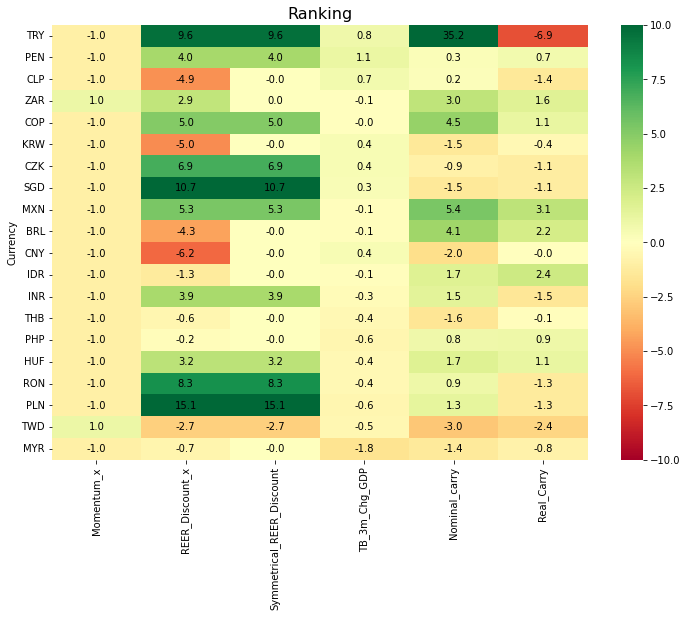

In [322]:

# Extract the data for the heatmap from the DataFrame
data = df[['Currency','Momentum_x', 'REER_Discount_x', 'Symmetrical_REER_Discount', 
           'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']]

# Select the columns to multiply by 100 (excluding 'Currency' and 'Momentum_x')
columns_to_multiply = ['REER_Discount_x', 'Symmetrical_REER_Discount', 'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']

# Multiply the selected columns by 100
data[columns_to_multiply] = data[columns_to_multiply] * 100 
           # Define the desired order from the image
order = ['CNY', 'BRL', 'IDR', 'THB', 'KRW', 'PEN', 'CLP', 'MXN', 'INR', 'COP', 'PHP', 'TRY', 'CZK', 'SGD', 'HUF', 'TWD', 'MYR', 'RON', 'PLN']


order = ['TRY',
'PEN',
'CLP',
'ZAR',
'COP',
'KRW',
'CZK',
'SGD',
'MXN',
'BRL',
'CNY',
'IDR',
'INR',
'THB',
'PHP',
'HUF',
'RON',
'PLN',
'TWD',
'MYR',
'EGP',
'EUR',
'JPY']
# Create a categorical column for 'Currency' with the desired order
data['Currency'] = pd.Categorical(data['Currency'], categories=order, ordered=True)
data = data.dropna()
# Sort the DataFrame based on the categorical 'Currency' column
data = data.sort_values('Currency').reset_index(drop=True)

data = data[['Currency','Momentum_x', 'REER_Discount_x', 'Symmetrical_REER_Discount', 
           'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']]
data_dict = data.to_dict(orient='list')


# Add the 'Currency' column to the data dictionary

# Convert the data dictionary to a DataFrame
df_heatmap = pd.DataFrame(data_dict)

# Set 'Currency' as the index
df_heatmap.set_index('Currency', inplace=True)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have your DataFrame 'df' loaded

# ... (your data preparation code)

# Create the heatmap with adjusted color scale
plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap, annot=True, fmt=".1f", 
            cmap="RdYlGn",  # Reverse the Red-Yellow-Green colormap
            center=0, 
            vmin=-10,  # Set the minimum value for the color scale
            vmax=10,   # Set the maximum value for the color scale
            annot_kws={"color": "black"}) 
plt.title("Ranking", fontsize=16)
plt.show()

In [76]:
df[['Currency','Real_Carry']]

,Currency,Real_Carry
0,BRL,0.023390
1,CLP,-0.017968
2,CNY,-0.018585
3,COP,0.009479
4,CZK,-0.003639
5,HUF,0.003994
6,IDR,0.016956
7,INR,0.005599
8,KRW,-0.013532
9,MXN,0.028664


C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_1752/3084671103.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[columns_to_multiply] = data[columns_to_multiply] * 100
C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_1752/3084671103.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Currency'] = pd.Categorical(data['Currency'], categories=order, ordered=True)


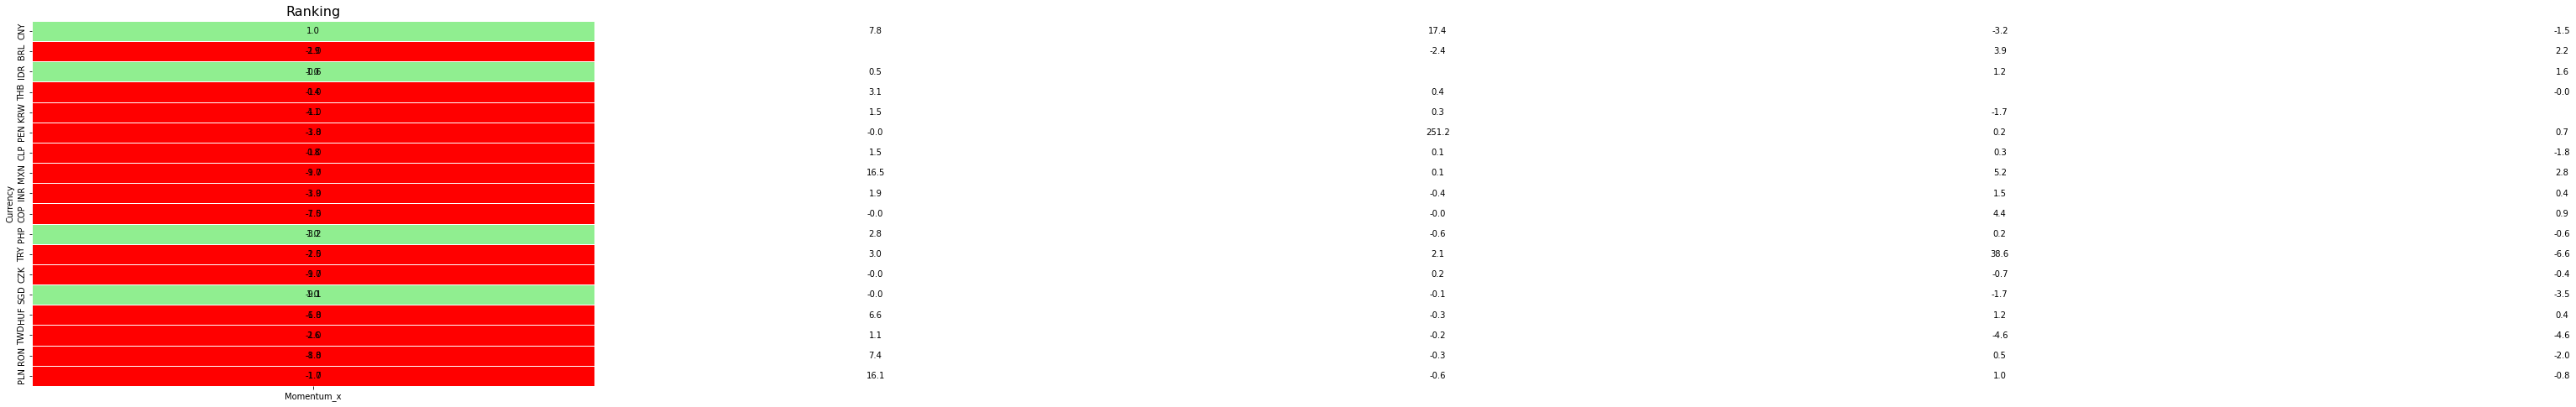

In [125]:

# Extract the data for the heatmap from the DataFrame
data = df[['Currency','Momentum_x', 'REER_Discount_x', 'Symmetrical_REER_Discount', 
           'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']]

# Select the columns to multiply by 100 (excluding 'Currency' and 'Momentum_x')
columns_to_multiply = ['REER_Discount_x', 'Symmetrical_REER_Discount', 'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']

# Multiply the selected columns by 100
data[columns_to_multiply] = data[columns_to_multiply] * 100 
           # Define the desired order from the image
order = ['CNY', 'BRL', 'IDR', 'THB', 'KRW', 'PEN', 'CLP', 'MXN', 'INR', 'COP', 'PHP', 'TRY', 'CZK', 'SGD', 'HUF', 'TWD', 'MYR', 'RON', 'PLN']

# Create a categorical column for 'Currency' with the desired order
data['Currency'] = pd.Categorical(data['Currency'], categories=order, ordered=True)
data = data.dropna()
# Sort the DataFrame based on the categorical 'Currency' column
data = data.sort_values('Currency').reset_index(drop=True)

data = data[['Currency','Momentum_x', 'REER_Discount_x', 'Symmetrical_REER_Discount', 
           'TB_3m_Chg_GDP', 'Nominal_carry', 'Real_Carry']]
data_dict = data.to_dict(orient='list')


# Add the 'Currency' column to the data dictionary

# Convert the data dictionary to a DataFrame
df_heatmap = pd.DataFrame(data_dict)

# Set 'Currency' as the index
df_heatmap.set_index('Currency', inplace=True)

# Create a custom colormap for Momentum
# Create a custom colormap for Momentum
cmap_momentum = sns.color_palette(['red', 'lightgreen'], as_cmap=True)

# Invert the data for REER_Discount_x and Symmetrical_REER_Discount
df_heatmap['REER_Discount_x'] = -df_heatmap['REER_Discount_x']
df_heatmap['Symmetrical_REER_Discount'] = -df_heatmap['Symmetrical_REER_Discount']

# Create the heatmap with adjusted color scales and custom colormap
plt.figure(figsize=(12, 8))

# Create a mask for Momentum column
mask_momentum = df_heatmap.columns != 'Momentum_x'

# Apply heatmap for all columns except Momentum
sns.heatmap(df_heatmap.loc[:, mask_momentum], annot=True, fmt=".1f", 
            cmap="RdYlGn", 
            center=0, 
            vmin=-10, 
            vmax=10, 
            annot_kws={"color": "black"},
            linewidths=.5,
            linecolor='white',
            cbar=False, 
            mask=np.equal(*np.indices(df_heatmap.loc[:, mask_momentum].shape))) 

# Apply custom colormap to 'Momentum_x' column
sns.heatmap(df_heatmap[['Momentum_x']], annot=True, fmt=".1f", 
            cmap=cmap_momentum, 
            center=0, 
            vmin=-1, 
            vmax=1, 
            annot_kws={"color": "black"},
            linewidths=.5, 
            linecolor='white',
            cbar=False) 

plt.title("Ranking", fontsize=16)
plt.show()

In [156]:
rub_index = df[df['Currency'] == 'RUB'].index
df = df.drop(index=rub_index)

In [185]:
df['TB_3m_Chg_GDP'].std()

0.00624819466040715

In [186]:
df[['REER_Discount_x']]

,REER_Discount_x
0,-0.065108
1,-0.067880
2,-0.061920
3,0.035740
4,0.068121
5,0.019053
6,-0.010976
7,0.058164
8,-0.049784
9,0.028983


In [157]:
### ZSCORE GOOD ##########
rub_index = df[df['Currency'] == 'RUB'].index
df = df.drop(index=rub_index)
models = {
    "RN": ["REER_Discount_x", "TB_3m_Chg_GDP", "Nominal_carry"],
    "CN": ["Conditional_REER_Discount", "TB_3m_Chg_GDP", "Nominal_carry"],
    "SN": ["Symmetrical_REER_Discount", "TB_3m_Chg_GDP", "Nominal_carry"],
    "RR": ["REER_Discount_x", "TB_3m_Chg_GDP", "Real_Carry"],
    "CR": ["Conditional_REER_Discount", "TB_3m_Chg_GDP", "Real_Carry"],
    "SR": ["Symmetrical_REER_Discount", "TB_3m_Chg_GDP", "Real_Carry"],
}

# Loop through each model and calculate the Z-score
for model_name, criteria in models.items():
    # Calculate the weighted average of the criteria for each currency
    df[f'zscore_{model_name}_part1'] = df.apply(
        lambda row: ( -row[criteria[0]] if df[criteria[0]].std() == 0
                    else -row[criteria[0]] / df[criteria[0]].std() 
                    if criteria[0] == "Symmetrical_REER_Discount" or "Conditionnal_REER_Discount"
                    else row[criteria[0]] / df[criteria[0]].std()),
        axis=1
    )
    df[f'zscore_{model_name}_part2'] = df.apply(
        lambda row: (row[criteria[1]] / df[criteria[1]].std()),
        axis=1
    )
    df[f'zscore_{model_name}_part3'] = df.apply(
        lambda row: (row[criteria[2]] / df[criteria[2]].std()),
        axis=1
    )

In [158]:
### ZSCORE SUM PARTS GOOD ####
for model_name, criteria in models.items():
    # ... (previous code for calculating part1, part2, part3) ...

    # Calculate the sum of the parts
    df[f'zscore_{model_name}'] = (
        (df[f'zscore_{model_name}_part1'] + 
        df[f'zscore_{model_name}_part2'] + 
        df[f'zscore_{model_name}_part3'])/3
    )

In [81]:
df[['REER_Discount_x','Conditional_REER_Discount','Nominal_carry','Currency']]

,REER_Discount_x,Conditional_REER_Discount,Nominal_carry,Currency
0,-0.063471,0,0.045263,BRL
1,-0.062536,0,0.003536,CLP
2,-0.059469,0,-0.013545,CNY
3,0.029525,0,0.043000,COP
4,0.065670,0,-0.008545,CZK
5,0.024078,0,0.015942,HUF
6,-0.006958,0,0.017091,IDR
7,0.057776,0,0.015466,INR
8,-0.050087,0,-0.013077,KRW
9,0.025133,0,0.056045,MXN


In [189]:
df[['zscore_CN','Currency']]

,zscore_CN,Currency
0,0.118139,BRL
1,0.396553,CLP
2,0.152830,CNY
3,0.167154,COP
4,0.173076,CZK
5,-0.158393,HUF
6,0.011040,IDR
7,0.018914,INR
8,0.163255,KRW
9,0.167302,MXN


In [61]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg', 'DayCount', 'Multiplier',
       '3m_imp_yield', 'calculated_value', 'CPI YOY', 'Real_Carry',
       'Nominal_carry', 'zscore_RN_part1', 'zscore_RN_part2',
       'zscore_RN_part3', 'zscore_CN_part1', 'zscore_CN_part2',
       'zscore_CN_part3', 'zscore_SN_part1', 'zscore_SN_part2',
       'zscore_SN_part3', 'zscore_RR_part1', 'zscore_RR_part2',
       'zscore_RR_part3', 'zscore_CR_part1', 'zscore_CR_part2',
       'zscore_CR_part3', 'zscore_SR_part1', 'zscore_SR_part2',
       'zscore_SR_part3', 'zscore_RN', 'zscore_CN', 'zscore_SN', 'zscore_RR',
       'zscore_CR', 

In [159]:
######## AGNOSTIC MODELS CONVICTIONS MAPPING FUNCTION #  GOOD #######################################
# Define the conviction score mapping based on sorted Z-score ranks
models = ["RN", "CN", "SN", "RR", "CR", "SR"]

conviction_mapping = {
    0: 3, 1: 3,  # Top 2
    2: 2, 3: 2, 4: 2,  # Next 3
    5: 1, 6: 1, 7: 1,  # Next 3
    8: 0, 9: 0, 10: 0, 11: 0,  # Next 4
    12: -1, 13: -1, 14: -1,  # Next 3
    15: -2, 16: -2, 17: -2,  # Next 3
    18: -3, 19: -3  # Last 2
}

# Loop through each model and calculate conviction scores
for model_name in models:
    # Rank currencies based on Z-scores for each model
    df[f'rank_{model_name}'] = df[f'zscore_{model_name}'].rank(ascending=False)

    # Sort the DataFrame by rank for the current model
    df_sorted = df.sort_values(by=f'rank_{model_name}')

    # Assign conviction scores based on the sorted rank
    df_sorted[f'conviction_{model_name}_Agn'] = df_sorted[f'rank_{model_name}'].apply(
        lambda rank: conviction_mapping.get(rank - 1, None) 
    )
    df[[f'conviction_{model_name}_Agn']] = df_sorted[[f'conviction_{model_name}_Agn']]
    # Merge the conviction scores back into the original DataFrame
    #df = pd.merge(df, df_sorted[[f'conviction_{model_name}_Agn']], left_index=True, right_index=True, how='left')

# Print or use the updated DataFrame 'df'
print(df)

   Currency  MOV_AVG_5D  MOV_AVG_20D  Momentum_x  3M Implied Vol      CPI  \
0       BRL      5.7721       5.7416          -1         14.3230  0.44000   
1       CLP    978.3400     961.1600          -1         13.4700  0.10000   
2       CNY      7.2314       7.1599          -1          5.9800  0.00000   
3       COP   4449.8200    4374.9800          -1         13.7825  0.24000   
4       CZK     23.9324      23.5432          -1          8.5200 -0.40000   
5       HUF    385.9000     378.3400          -1         11.3750 -0.10000   
6       IDR  15823.0000   15726.0000          -1          7.4850 -0.12000   
7       INR     84.3930      84.2000          -1          2.5725  4.52099   
8       KRW   1401.7200    1389.2200          -1          8.9250  0.10000   
9       MXN     20.4138      20.1439          -1         13.9980  0.05000   
10      MYR      4.4650       4.3911          -1          6.5400  0.00000   
11      PEN      3.7998       3.7742          -1          5.6825 -0.12000   

In [93]:
df.columns 

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg', 'DayCount', 'Multiplier',
       '3m_imp_yield', 'calculated_value', 'CPI YOY', 'Real_Carry',
       'Nominal_carry', 'zscore_RN_part1', 'zscore_RN_part2',
       'zscore_RN_part3', 'zscore_CN_part1', 'zscore_CN_part2',
       'zscore_CN_part3', 'zscore_SN_part1', 'zscore_SN_part2',
       'zscore_SN_part3', 'zscore_RR_part1', 'zscore_RR_part2',
       'zscore_RR_part3', 'zscore_CR_part1', 'zscore_CR_part2',
       'zscore_CR_part3', 'zscore_SR_part1', 'zscore_SR_part2',
       'zscore_SR_part3', 'zscore_RN', 'zscore_CN', 'zscore_SN', 'zscore_RR',
       'zscore_CR', 

In [160]:
### GOOD VERSION 2 
def round_2x_to_half(x):
    """
    Rounds 2 times a number to the closest multiple of 0.5,
    rounding towards zero for negative numbers.
    """
    two_x = 2 * x
    return round(two_x * 2) / 2 if two_x >= 0 else -np.round(-two_x * 2) / 2

round_2x_to_half(-0.38)

-1.0

In [191]:
### GOOD 

def round_2x_to_half(x):
    """Rounds 2 times a number to the closest multiple of 0.5."""
    return round(x * 4) / 2

round_2x_to_half(-0.38)

-1.0

In [161]:
######### AWARE MODEL ###########
models = {
    "RN": ["REER_Discount_x", "TB_3m_Chg_GDP", "Nominal_carry"],
    "CN": ["Conditional_REER_Discount", "TB_3m_Chg_GDP", "Nominal_carry"],
    "SN": ["Symmetrical_REER_Discount", "TB_3m_Chg_GDP", "Nominal_carry"],
    "RR": ["REER_Discount_x", "TB_3m_Chg_GDP", "Real_Carry"],
    "CR": ["Conditional_REER_Discount", "TB_3m_Chg_GDP", "Real_Carry"],
    "SR": ["Symmetrical_REER_Discount", "TB_3m_Chg_GDP", "Real_Carry"],
}

for model_name in models:
    # Calculate rank
    df[f'rank_{model_name}'] = df[f'zscore_{model_name}'].rank(ascending=False)

    # Calculate conviction_{model_name}_Awa (corrected formula)
    df[f'conviction_{model_name}_Awa'] = df.apply(
        lambda row: max(-3, min(3, 
                                np.round(row[f'zscore_{model_name}']*4)/2  
                                if row[f'rank_{model_name}'] <= 8 
                                else 0 
                                if 9 <= row[f'rank_{model_name}'] <= 12 
                                else round_2x_to_half(row[f'zscore_{model_name}'])
                                if row[f'rank_{model_name}'] >= 12 
                                else None)), 
        axis=1
    )



In [60]:
df[['TB_3m_Chg_GDP','Currency']]

,TB_3m_Chg_GDP,Currency
0,-0.005521,BRL
1,0.007153,CLP
2,0.003945,CNY
3,-0.000275,COP
4,0.003929,CZK
5,-0.004238,HUF
6,-0.000875,IDR
7,-0.002563,INR
8,0.004087,KRW
9,-0.001174,MXN


In [57]:
df[["zscore_CN", "Currency"]]

,zscore_CN,Currency
0,0.118682,BRL
1,0.428868,CLP
2,0.176201,CNY
3,0.155495,COP
4,0.175753,CZK
5,-0.162636,HUF
6,0.004672,IDR
7,0.013935,INR
8,0.163938,KRW
9,0.155028,MXN


In [56]:
df[["zscore_CN", "Currency"]].sort_values(by='zscore_CN', ascending = False)

,zscore_CN,Currency
18,1.903984,TRY
11,0.622810,PEN
1,0.428868,CLP
2,0.176201,CNY
4,0.175753,CZK
8,0.163938,KRW
3,0.155495,COP
9,0.155028,MXN
0,0.118682,BRL
20,0.086087,ZAR


In [75]:
df[["conviction_CN_Awa", "Currency"]]

,conviction_CN_Awa,Currency
0,0.0,BRL
1,1.0,CLP
2,0.5,CNY
3,0.5,COP
4,0.5,CZK
5,-0.5,HUF
6,0.0,IDR
7,0.0,INR
8,0.5,KRW
9,0.5,MXN


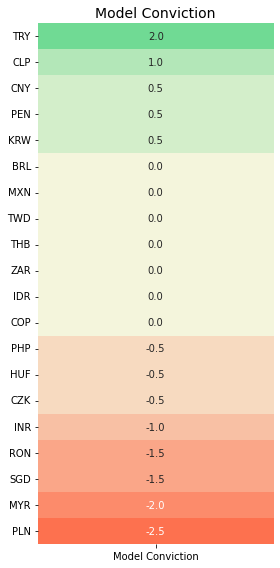

In [195]:
from matplotlib.colors import LinearSegmentedColormap

data = df[["conviction_SN_Awa", "Currency"]].sort_values(by='conviction_SN_Awa', ascending = False)
cmap = LinearSegmentedColormap.from_list(
    "rg", ["#FF5733", "#F5F5DC", "#2ECC71"], N=256
)

# Plot the table with color gradient and beige background
fig, ax = plt.subplots(figsize=(4, 8))

sns.heatmap(data[['conviction_SN_Awa']], annot=True, fmt=".1f", cmap=cmap, 
            center=0, vmin=-3, vmax=3, ax=ax, cbar=False,
            yticklabels=data['Currency'])

# Set beige background
ax.set_facecolor('#F5F5DC') 

ax.set_xticklabels(['Model Conviction'], rotation=0)
plt.title('Model Conviction', fontsize=14)
plt.tight_layout()
plt.show()

In [142]:
data = df[['zscore_CR','Currency']].sort_values(by='zscore_CR', ascending = False)

In [100]:
### SIZE TEST 
# Define inputs
concentration_limit = 0.05
i2_value = -0.003
k2_value = 0.005
ab38_value = 7
avg_implied_vol = 10.13  # $AA$23
implied_vol = 8.25       # H$23
conviction = 0.5        # H$37
nominal_carry = 0.0172  # H$12

# Create a sample DataFrame with the given inputs
data = {'3M Implied Vol': [implied_vol], 
        'conviction_CR_Awa': [conviction],  # Assuming this is the relevant conviction column
        'Nominal_carry': [nominal_carry]}
x = pd.DataFrame(data)

# Calculate the size using the Python code (adapted for a single row)
size = (
    i2_value / nominal_carry
    if (
        max(
            min(
                avg_implied_vol / implied_vol * conviction * ab38_value * k2_value / 2,
                concentration_limit
            ),
            -concentration_limit
        ) * nominal_carry < i2_value
    )
    else (
        max(
            min(
                avg_implied_vol / implied_vol * conviction * ab38_value * k2_value / 2,
                concentration_limit
            ),
            -concentration_limit
        )
    )
)

# Print the result
print(f"Calculated size: {size}")

Calculated size: 0.010743939393939394


In [162]:
# Define inputs
### SIZE GOOD 
concentration_limit = 0.05
i2_value = -0.003
step_size = 0.005
ratio = 6

models = ["RN", "CN", "SN", "RR", "CR", "SR"]

# Calculate the average 3M Implied Vol once outside the loop
avg_implied_vol = df['3M Implied Vol'].mean()

for model_name in models:
    for method in ["Agn", "Awa"]:
        model = f"{model_name}-{method}"
        conviction_col = f"conviction_{model_name}_{method}"

        df[f'size_{model}'] = df.apply(
            lambda row: (
                i2_value / row['Nominal_carry']
                if (
                    max(
                        min(
                            avg_implied_vol / row['3M Implied Vol'] * row[conviction_col] * ratio * step_size / 2,
                            concentration_limit
                        ),
                        -concentration_limit
                    ) * row['Nominal_carry'] < i2_value
                )
                else (
                    max(
                        min(
                            avg_implied_vol / row['3M Implied Vol'] * row[conviction_col] * ab38_value * k2_value / 2,
                            concentration_limit
                        ),
                        -concentration_limit
                    )
                )
            ),
            axis=1
        )


In [77]:
df[['size_CN-Awa','Currency']]

,size_CN-Awa,Currency
0,0.000000,BRL
1,0.010501,CLP
2,0.011789,CNY
3,0.005142,COP
4,0.008245,CZK
5,-0.006178,HUF
6,0.000000,IDR
7,0.000000,INR
8,0.007877,KRW
9,0.005052,MXN


In [61]:
df_backup = df

# Plotting analyst sizes 

# Zscores from fiche Today, Annualzed STDV = Tracking error in excel 
# Compute the beta 
# Compute Carry contribution 
# Re compute model conviction 
# plot implied volatility 
# Compute Size from fiche today 


In [197]:
data_prices

,BRL,CLP,CNY,COP,CZK,HUF,IDR,MYR,MXN,PEN,...,PLN,RON,RUB,ZAR,THB,TRY,INR,SGD,TWD,KRW
2019-11-15,NaN,777.29,7.0084,3426.23,23.1709,302.85,14059.0,4.1530,19.1790,3.3643,...,3.8689,4.3153,63.7575,14.7114,30.253,5.7477,71.6350,1.3605,30.528,1163.59
2019-11-18,4.2092,772.66,7.0260,3442.27,23.1015,302.94,14094.0,4.1555,19.3130,3.3743,...,3.8786,4.3127,63.8675,14.8134,30.189,5.7357,71.9600,1.3605,30.492,1167.36
2019-11-19,4.1994,787.14,7.0276,3439.50,23.0720,300.49,14092.0,4.1576,19.3440,3.3767,...,3.8678,4.3112,63.8655,14.7631,30.187,5.6990,71.8304,1.3609,30.505,1168.35
2019-11-20,4.1968,795.35,7.0358,3442.70,23.0470,301.22,14103.0,4.1655,19.4634,3.3835,...,3.8784,4.3200,63.8302,14.7808,30.187,5.6998,71.7940,1.3622,30.504,1170.83
2019-11-21,4.1954,795.28,7.0293,3420.40,23.0979,302.39,14093.0,4.1695,19.3840,3.3740,...,3.8856,4.3210,63.6962,14.6842,30.211,5.6970,71.7539,1.3631,30.521,1176.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-11,5.7573,980.28,7.2152,NaN,23.7784,385.18,15761.0,4.4100,20.3424,3.7785,...,4.0946,4.6711,96.1250,17.9402,34.534,34.3400,84.4206,1.3339,32.329,1401.28
2024-11-12,5.7572,985.60,7.2355,4452.00,23.8945,386.66,15802.0,4.4400,20.5894,3.7899,...,4.0943,4.6839,98.3750,18.1109,34.831,34.3552,84.3963,1.3382,32.439,1407.72
2024-11-13,5.7976,979.08,7.2333,4478.56,23.9331,386.15,15837.0,4.4480,20.5126,3.8083,...,4.1096,4.7112,98.5869,18.2213,34.881,34.3553,84.4227,1.3428,32.470,1405.71
2024-11-14,5.7966,975.51,7.2279,4486.00,24.0179,386.06,15908.0,4.4860,20.4044,3.7991,...,4.1051,4.7252,98.9494,18.2707,34.997,34.3365,84.4570,1.3462,32.549,1406.94


In [ ]:
end_date = pd.Timestamp.today()
start_date = end_date - pd.Timedelta(days=510)
data_prices = data_prices.loc[start_date:end_date]

# Calculate daily returns using pct_change()
daily_rt = data_prices.pct_change().dropna()

print(daily_rt)

TypeError: Cannot compare Timestamp with datetime.date. Use ts == pd.Timestamp(date) or ts.date() == date instead.

In [62]:
data_prices = data_prices.iloc[-510:,:]

In [104]:
data_prices

,BRL,CLP,CNY,COP,CZK,HUF,IDR,MYR,MXN,PEN,...,PLN,RON,RUB,ZAR,THB,TRY,INR,SGD,TWD,KRW
2022-12-02,5.2194,883.44,7.0535,4776.65,23.1248,389.52,15428.0,4.3880,19.4001,3.8377,...,4.4403,4.6768,62.0671,17.5052,34.787,18.6392,81.4100,1.3516,30.529,1297.88
2022-12-05,5.2835,896.03,6.9625,4839.85,23.1662,394.20,15468.0,4.3686,19.7548,3.8565,...,4.4901,4.6869,62.5438,17.4239,35.037,18.6359,81.8860,1.3576,30.485,1305.70
2022-12-06,5.2378,879.29,6.9950,4834.00,23.2428,392.33,15618.0,4.3966,19.7710,3.8352,...,4.4807,4.6948,63.2006,17.3365,35.123,18.6334,82.3445,1.3590,30.643,1320.11
2022-12-07,5.2161,866.10,6.9700,4827.99,23.1137,391.15,15638.0,4.3970,19.6764,3.8226,...,4.4640,4.6782,63.3775,17.1622,34.952,18.6417,82.2485,1.3554,30.630,1315.30
2022-12-08,5.2167,864.10,6.9674,NaN,23.0138,395.75,15621.0,4.3983,19.6301,NaN,...,4.4357,4.6591,63.2295,17.1659,34.720,18.6419,82.3005,1.3536,30.665,1317.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-08,5.7352,970.46,7.1761,4361.71,23.5594,379.76,15649.0,4.3820,20.1774,3.7660,...,4.0348,4.6418,97.6000,17.6002,34.302,34.3715,84.3989,1.3255,32.118,1398.19
2024-11-11,5.7573,980.28,7.2152,NaN,23.7784,385.18,15761.0,4.4100,20.3424,3.7785,...,4.0946,4.6711,96.1250,17.9402,34.534,34.3400,84.4206,1.3339,32.329,1401.28
2024-11-12,5.7572,985.60,7.2355,4452.00,23.8945,386.66,15802.0,4.4400,20.5894,3.7899,...,4.0943,4.6839,98.3750,18.1109,34.831,34.3552,84.3963,1.3382,32.439,1407.72
2024-11-13,5.7976,979.08,7.2333,4478.56,23.9331,386.15,15837.0,4.4480,20.5126,3.8083,...,4.1096,4.7112,98.5869,18.2213,34.881,34.3553,84.4227,1.3428,32.470,1405.71


In [103]:
data_prices.shift()

,BRL,CLP,CNY,COP,CZK,HUF,IDR,MYR,MXN,PEN,...,PLN,RON,RUB,ZAR,THB,TRY,INR,SGD,TWD,KRW
2022-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-05,5.2194,883.44,7.0535,4776.65,23.1248,389.52,15428.0,4.3880,19.4001,3.8377,...,4.4403,4.6768,62.0671,17.5052,34.787,18.6392,81.4100,1.3516,30.529,1297.88
2022-12-06,5.2835,896.03,6.9625,4839.85,23.1662,394.20,15468.0,4.3686,19.7548,3.8565,...,4.4901,4.6869,62.5438,17.4239,35.037,18.6359,81.8860,1.3576,30.485,1305.70
2022-12-07,5.2378,879.29,6.9950,4834.00,23.2428,392.33,15618.0,4.3966,19.7710,3.8352,...,4.4807,4.6948,63.2006,17.3365,35.123,18.6334,82.3445,1.3590,30.643,1320.11
2022-12-08,5.2161,866.10,6.9700,4827.99,23.1137,391.15,15638.0,4.3970,19.6764,3.8226,...,4.4640,4.6782,63.3775,17.1622,34.952,18.6417,82.2485,1.3554,30.630,1315.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-08,5.6924,949.10,7.1419,4308.04,23.3728,374.53,15570.0,4.4040,19.8016,3.7510,...,3.9917,4.6061,97.5000,17.3063,34.009,34.2364,84.2992,1.3201,32.251,1381.45
2024-11-11,5.7352,970.46,7.1761,4361.71,23.5594,379.76,15649.0,4.3820,20.1774,3.7660,...,4.0348,4.6418,97.6000,17.6002,34.302,34.3715,84.3989,1.3255,32.118,1398.19
2024-11-12,5.7573,980.28,7.2152,NaN,23.7784,385.18,15761.0,4.4100,20.3424,3.7785,...,4.0946,4.6711,96.1250,17.9402,34.534,34.3400,84.4206,1.3339,32.329,1401.28
2024-11-13,5.7572,985.60,7.2355,4452.00,23.8945,386.66,15802.0,4.4400,20.5894,3.7899,...,4.0943,4.6839,98.3750,18.1109,34.831,34.3552,84.3963,1.3382,32.439,1407.72


In [59]:
returns = data_prices.shift()/data_prices -1 
returns = returns.dropna()
returns = returns.drop('RUB', axis=1).copy()


In [107]:
returns[-12:]

,BRL,CLP,CNY,COP,CZK,HUF,IDR,MYR,MXN,PEN,...,PLN,RON,RUB,ZAR,THB,TRY,INR,SGD,TWD,KRW
2024-10-30,-0.000226,-0.007245,0.001672,-0.006565,0.002344,-0.001173,0.004847,-0.000160,-0.004362,0.001275,...,-0.000224,0.003470,0.004730,0.000748,-0.002754,-0.000053,-0.001112,0.001361,0.002530,0.003487
2024-10-31,-0.004199,0.000645,-0.000407,-0.001487,0.004986,0.000107,-0.000828,NaN,0.005769,-0.002278,...,0.002549,0.002560,-0.003399,0.002926,-0.000651,0.000461,0.000136,0.001894,NaN,0.004149
2024-11-01,-0.014122,0.000281,-0.001122,-0.002696,-0.005213,-0.004539,-0.008780,NaN,-0.012157,-0.001323,...,-0.006283,-0.004291,-0.006866,-0.002945,-0.005035,-0.001998,NaN,-0.004751,NaN,-0.004824
2024-11-04,0.014868,0.006999,0.004128,NaN,0.004277,0.004185,0.003677,0.001143,0.008883,0.001723,...,0.005443,0.003563,-0.008817,0.007119,0.006609,-0.000565,NaN,0.004850,0.000784,0.005075
2024-11-05,0.006613,-0.001705,-0.000887,NaN,0.005132,0.002431,0.002542,0.006908,-0.000333,0.000000,...,0.005019,0.004921,0.011236,0.007500,0.003868,0.001006,0.000630,0.004032,-0.001565,-0.004082
2024-11-06,0.012065,-0.004716,-0.010322,-0.000870,-0.019353,-0.020236,-0.004366,-0.014075,0.001100,-0.001799,...,-0.017868,-0.018416,0.005636,-0.012587,-0.021399,0.003037,-0.002333,-0.013880,-0.007609,-0.015610
2024-11-07,-0.002565,0.012148,0.005209,0.024178,0.010777,0.019918,0.014965,0.000227,0.014570,0.007678,...,0.016484,0.006752,-0.002818,0.018207,0.009939,-0.000850,0.000130,0.009696,-0.001581,0.014152
2024-11-08,-0.007463,-0.022010,-0.004766,-0.012305,-0.007920,-0.013772,-0.005048,0.005021,-0.018625,-0.003983,...,-0.010682,-0.007691,-0.001025,-0.016699,-0.008542,-0.003931,-0.001181,-0.004074,0.004141,-0.011973
2024-11-11,-0.003839,-0.010018,-0.005419,NaN,-0.009210,-0.014071,-0.007106,-0.006349,-0.008111,-0.003308,...,-0.014605,-0.006273,0.015345,-0.018952,-0.006718,0.000917,-0.000257,-0.006297,-0.006527,-0.002205
2024-11-12,0.000017,-0.005398,-0.002806,NaN,-0.004859,-0.003828,-0.002595,-0.006757,-0.011996,-0.003008,...,0.000073,-0.002733,-0.022872,-0.009425,-0.008527,-0.000442,0.000288,-0.003213,-0.003391,-0.004575


In [108]:
size_columns = [col for col in df.columns if col.startswith('size_')]


In [109]:
size_columns

['size_RN-Agn',
 'size_RN-Awa',
 'size_CN-Agn',
 'size_CN-Awa',
 'size_SN-Agn',
 'size_SN-Awa',
 'size_RR-Agn',
 'size_RR-Awa',
 'size_CR-Agn',
 'size_CR-Awa',
 'size_SR-Agn',
 'size_SR-Awa']

# VOLATILITY OF PORTFOLIO FOR EACH MODEL 

In [242]:
### TESTING STD DEV CALCULUS TO ALIGN WITH EXCEL 
# New sizes (as percentages)
new_sizes_percent = [0.0, 2.1, 0.0, 1.1, 3.7, -2.7, -1.8, -5.0, 0.8, 5.0, -2.1, -3.0, -4.0, 0.0, -4.7, 1.9, -5.0, 0.0, 5.0, 1.4]

# Indices (currency codes) - assuming these are the same
indices = ['BRL', 'CLP', 'CNY', 'COP', 'CZK', 'HUF', 'IDR', 'MYR', 'MXN', 'PEN', 'PHP', 'PLN', 'RON', 'ZAR', 'THB', 'TRY', 'INR', 'SGD', 'TWD', 'KRW']

# Create the pandas Series
benchmark_sizes = pd.Series(new_sizes_percent, index=indices) / 100 # Divide by 100 to convert percentages to decimals

# Assuming you have a DataFrame 'returns' with daily returns for the assets

# Transpose the benchmark sizes to match the dimensions for matrix multiplication
weights = benchmark_sizes.values 

# Calculate the portfolio returns
portfolio_returns = np.dot(returns.values, weights)

# Calculate the annualized standard deviation
annualized_std = np.std(portfolio_returns) * np.sqrt(252)

# Print the result
print(f"Annualized Standard Deviation: {annualized_std}")

Annualized Standard Deviation: 0.008835838135309512


In [245]:
size_columns

['size_RN-Agn',
 'size_RN-Awa',
 'size_CN-Agn',
 'size_CN-Awa',
 'size_SN-Agn',
 'size_SN-Awa',
 'size_RR-Agn',
 'size_RR-Awa',
 'size_CR-Agn',
 'size_CR-Awa',
 'size_SR-Agn',
 'size_SR-Awa']

In [115]:
### V2
for model_name in size_columns:
    # Get the sizes for the current model
    weights = df[model_name]#.values.reshape(-1, 1)

    # Calculate the portfolio returns for the current model
    portfolio_returns = np.dot(returns.values, weights)

    # Calculate the annualized standard deviation for the current model
    annualized_std = np.std(portfolio_returns) * np.sqrt(252)

    # Store the result in a new column
    df[f'std_{model_name}_step1'] = annualized_std


In [116]:
df[['std_size_CN-Agn_step1']]

,std_size_CN-Agn_step1
0,0.00793
1,0.00793
2,0.00793
3,0.00793
4,0.00793
5,0.00793
6,0.00793
7,0.00793
8,0.00793
9,0.00793


# Store the dataframe daily 

In [64]:
from pathlib import Path  
from datetime import date

today = date.today()

today = date.today()

# Create the filepath dynamically using today's date
filepath = Path(f'C:/Users/UT3P5T/Desktop/dataframe daily/data_daily{today.strftime("%Y_%m_%d")}.xlsx')

# Ensure the directory exists
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_excel(filepath, index=False)

C:\Users\UT3P5T\AppData\Local\Temp\1/ipykernel_11964/1221875777.py:13: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.2' currently installed).
  df.to_excel(filepath, index=False)


In [90]:
import pandas as pd
from pathlib import Path
from datetime import date
import openpyxl


def append_df_to_daily_excel(df, base_filepath):


    today = date.today()
    filepath = base_filepath / f"{today.strftime('%Y_%m_%d')}.xlsx"

    # Check if the file exists
    if filepath.exists():
        # Append to existing file
        append_df_to_excel(str(filepath), df, index=False)  # Using the function from the previous response
    else:
        # Create a new Excel file for today's date
        filepath.parent.mkdir(parents=True, exist_ok=True)
        df.to_excel(filepath, index=False)

def append_df_to_excel(existing_file, df_to_add, sheet_name='Sheet1', startrow=None, truncate_sheet=False, **to_excel_kwargs):
  
    # Load the workbook.
    writer = pd.ExcelWriter(existing_file, engine='openpyxl', mode='a', if_sheet_exists='overlay') # Crucial for appending
    book = openpyxl.load_workbook(existing_file)

    try:
        writer.book = book 
        writer.sheets = {ws.title: ws for ws in book.worksheets}


        if startrow is None and sheet_name in writer.sheets:
            startrow = writer.sheets[sheet_name].max_row  # Get last row of existing data


        df_to_add.to_excel(writer, sheet_name=sheet_name, startrow=startrow, header=startrow==0, **to_excel_kwargs)  


        writer.close() # Save the changes

    except KeyError:
        raise ValueError(f"Sheet '{sheet_name}' not found in '{existing_file}'")





base_file_path = Path("C:/Users/UT3P5T/Desktop/dataframe daily/data_daily2024_11_05.xlsx")  # The base path

append_df_to_daily_excel(df, base_file_path) # Append (or create if new day)




new_df = pd.DataFrame({'A': [10, 11, 12], 'B': [13, 14, 15]})  # Another DataFrame
append_df_to_daily_excel(new_df, base_file_path)  

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\UT3P5T\\Desktop\\dataframe daily\\data_daily2024_11_05.xlsx'

In [65]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg', 'DayCount', 'Multiplier',
       '3m_imp_yield', 'calculated_value', 'CPI YOY', 'Real_Carry',
       'Nominal_carry', 'zscore_RN_part1', 'zscore_RN_part2',
       'zscore_RN_part3', 'zscore_CN_part1', 'zscore_CN_part2',
       'zscore_CN_part3', 'zscore_SN_part1', 'zscore_SN_part2',
       'zscore_SN_part3', 'zscore_RR_part1', 'zscore_RR_part2',
       'zscore_RR_part3', 'zscore_CR_part1', 'zscore_CR_part2',
       'zscore_CR_part3', 'zscore_SR_part1', 'zscore_SR_part2',
       'zscore_SR_part3', 'zscore_RN', 'zscore_CN', 'zscore_SN', 'zscore_RR',
       'zscore_CR', 

BRL	CLP	CNY	COP	CZK	HUF	IDR	MYR	MXN	PEN	PHP	PLN	RON	RUB	ZAR	THB	TRY	INR	SGD	TWD	KRW	UAH	EGP	EUR	JPY	Avg/Std


In [67]:
df[['REER_Discount_x','TB_3m_Chg_GDP']]

,REER_Discount_x,TB_3m_Chg_GDP
0,-0.058526,-0.001242
1,-0.066729,0.007749
2,-0.063053,0.003956
3,0.047012,-0.000275
4,0.066137,0.003929
5,0.022698,-0.004238
6,-0.009120,-0.001094
7,0.058608,-0.000845
8,-0.048469,0.004087
9,0.032022,-0.001174


In [68]:
df_save = df[['Currency','Momentum_x', '3M Implied Vol','REER_Discount_y','TB_3m_Chg_GDP','Nominal_carry','Real_Carry']].rename(columns={'REER_Discount_y': 'REER_discount'})


In [69]:
df_save 

,Currency,Momentum_x,3M Implied Vol,REER_discount,TB_3m_Chg_GDP,Nominal_carry,Real_Carry
0,BRL,-1,14.4400,-0.058526,-0.001242,0.048267,0.027152
1,CLP,-1,13.4400,-0.066729,0.007749,0.003793,-0.016646
2,CNY,-1,6.0150,-0.063053,0.003956,-0.009471,0.013491
3,COP,-1,13.7475,0.047012,-0.000275,0.045143,0.017605
4,CZK,-1,8.6000,0.066137,0.003929,-0.008857,-0.010987
5,HUF,-1,11.5000,0.022698,-0.004238,0.016642,0.010932
6,IDR,-1,7.4700,-0.009120,-0.001094,0.016615,0.025988
7,INR,-1,2.5500,0.058608,-0.000845,0.015757,-0.019119
8,KRW,-1,9.0000,-0.048469,0.004087,-0.014281,-0.001662
9,MXN,-1,14.0170,0.032022,-0.001174,0.057030,0.035894


In [67]:
import pandas as pd
import zipfile

try:
    zf = zipfile.ZipFile("Metrics data.xlsx")  # Test if it's a valid zip archive
    zf.close() # close the file
    x = pd.read_excel("Metrics data.xlsx", engine="openpyxl") 
except zipfile.BadZipFile:
    print("File is corrupted or not a valid Excel file.")
    # Try online repair tools or Excel's Open and Repair feature here
    # If you can partially recover data, save it to a new file and then try reading that with Pandas
    try: # Try recovering data if there is sheet1 present
      x = pd.read_excel("Metrics data.xlsx", sheet_name="Sheet1")
    except:
      print("Could not recover any data")

except FileNotFoundError:
    print("File not found. Check the file path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

File is corrupted or not a valid Excel file.
Could not recover any data


In [64]:
import glob

data_file = pd.ExcelFile('Metrics data.xlsx')
metrics = pd.read_excel(data_file, 'Metrics',header=0)
metrics = metrics.rename(columns={'Unnamed: 0': 'metric'})


ValueError: Excel file format cannot be determined, you must specify an engine manually.

In [66]:
df

,Currency,MOV_AVG_5D,MOV_AVG_20D,Momentum_x,3M Implied Vol,CPI,REER_x,REER_5Y_avg_x,REER_y,REER_5Y_avg_y,...,size_CN-Agn,size_CN-Awa,size_SN-Agn,size_SN-Awa,size_RR-Agn,size_RR-Awa,size_CR-Agn,size_CR-Awa,size_SR-Agn,size_SR-Awa
0,BRL,5.7700,5.7411,-1,14.3200,0.44000,103.71,107.531905,103.71,107.531905,...,0.000000,0.000000,0.009863,0.000000,0.029588,0.014794,0.019725,0.009863,0.019725,0.009863
1,CLP,978.4300,961.1900,-1,13.4500,0.10000,101.29,102.934762,101.29,102.934762,...,0.021001,0.010501,0.031502,0.010501,0.021001,0.010501,0.000000,0.000000,0.010501,0.005250
2,CNY,7.2314,7.1599,-1,5.9900,0.00000,91.33,98.337302,91.33,98.337302,...,0.047157,0.011789,0.047157,0.011789,0.050000,0.035367,0.047157,0.023578,0.050000,0.023578
3,COP,4449.8200,4374.9800,-1,13.7325,0.24000,105.84,99.467778,105.84,99.467778,...,0.010285,0.005142,0.000000,0.000000,0.000000,0.000000,0.010285,0.005142,0.000000,0.000000
4,CZK,23.9348,23.5438,-1,8.5650,-0.40000,120.15,111.364127,120.15,111.364127,...,0.032979,0.008245,-0.016490,-0.008245,-0.016490,-0.008245,0.000000,0.000000,-0.016490,-0.016490
5,HUF,385.9400,378.3500,-1,11.4300,-0.10000,108.43,102.842222,108.43,102.842222,...,-0.012356,-0.006178,-0.012356,-0.006178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,IDR,15823.0000,15726.0000,-1,7.4700,-0.12000,100.19,100.608571,100.19,100.608571,...,0.000000,0.000000,0.018907,0.000000,0.018907,0.018907,0.037814,0.018907,0.037814,0.018907
7,INR,84.3930,84.2000,-1,2.5475,4.52099,99.34,100.289683,99.34,100.289683,...,0.000000,0.000000,-0.050000,-0.050000,-0.050000,-0.050000,-0.050000,-0.050000,-0.050000,-0.050000
8,KRW,1401.7200,1389.2200,-1,8.9650,0.10000,94.78,97.759683,94.78,97.759683,...,0.015754,0.007877,0.031508,0.007877,0.031508,0.015754,0.015754,0.007877,0.015754,0.007877
9,MXN,20.4169,20.1447,-1,13.9770,0.05000,120.51,114.938095,120.51,114.938095,...,0.010105,0.005052,0.000000,0.000000,0.010105,0.005052,0.030314,0.010105,0.020209,0.005052


# Here we continue the whitepaper and implement its formulae 

In [96]:
df_backup.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y', 'spot_adj',
       'infla_adj', 'proxy', 'REER_Discount_x', 'REER_Discount_y',
       'Momentum_y', 'Conditional_REER_Discount', 'Symmetrical_REER_Discount',
       'GDP', 'TB_3m_Chg_GDP', 'SPOT_MID', 'FWD_SCALE', 'FPA3M_MID',
       'FPA1M_MID', 'security', 'TB', 'TB_3m_Chg', 'DayCount', 'Multiplier',
       '3m_imp_yield', 'calculated_value', 'CPI YOY', 'Real_Carry',
       'Nominal_carry', 'zscore_RN_part1', 'zscore_RN_part2',
       'zscore_RN_part3', 'zscore_CN_part1', 'zscore_CN_part2',
       'zscore_CN_part3', 'zscore_SN_part1', 'zscore_SN_part2',
       'zscore_SN_part3', 'zscore_RR_part1', 'zscore_RR_part2',
       'zscore_RR_part3', 'zscore_CR_part1', 'zscore_CR_part2',
       'zscore_CR_part3', 'zscore_SR_part1', 'zscore_SR_part2',
       'zscore_SR_part3', 'zscore_RN', 'zscore_CN', 'zscore_SN', 'zscore_RR',
       'zscore_CR', 

In [70]:
import math

In [90]:
ratio

[6]

In [188]:
import pandas as pd

# Define models and constants
models = ["RN", "CN", "SN", "RR", "CR", "SR"]
concentration_limit = 0.05
carry_cap = -0.003
lower_te_bound = 0.008
upper_te_bound = 0.012
# These values were missing, I have added them based on the 'correct' code.
i2_value = -0.003
step_size = 0.005
ratio = 6
default = 0.03

# Calculate the average 3M Implied Vol once outside the loop
avg_implied_vol = df['3M Implied Vol'].mean()


# Loop through each model and calibrate position sizes
for model_name in models:
    for method in ["Agn", "Awa"]:
        model = f"{model_name}-{method}"
        conviction_col = f"conviction_{model_name}_{method}"
        standard_size = 0.03 if method == "Agn" else 0.035

        # Step 1: Initial size calculation (Corrected to match the first code)
        df[f'size_0_{model}'] = df.apply(
            lambda row: (
                i2_value / row['Nominal_carry']
                if (
                    max(
                        min(
                            avg_implied_vol / row['3M Implied Vol'] * row[conviction_col] * ratio * step_size / 2,
                            concentration_limit
                        ),
                        -concentration_limit
                    ) * row['Nominal_carry'] < i2_value
                )
                else (
                    max(
                        min(
                            avg_implied_vol / row['3M Implied Vol'] * row[conviction_col] * ratio * step_size / 2,
                            concentration_limit
                        ),
                        -concentration_limit
                    )
                )
            ),
            axis=1
        )



        # Step 1 (cont.): Carry control (unchanged)
        df[f'size_1_{model}'] = df.apply(
            lambda row: row[f'size_0_{model}']
            if row[f'size_0_{model}'] * row['Nominal_carry'] >= carry_cap
            else carry_cap / row['Nominal_carry'],
            axis=1
        )




In [189]:
### CHECK WHY MULTIPLY BY 100 TO OBTAIN THE RIGHT RESULT 
for model_name in models:
    for method in ["Agn", "Awa"]:
        model = f"{model_name}-{method}"
        conviction_col = f"conviction_{model_name}_{method}"
        standard_size = 0.03 if method == "Agn" else 0.035 
        implied_vol_sum = df['3M Implied Vol'].sum()

        for u in range(2, 6):  # u in [2, 3, 4, 5, 6]  (Steps 2-6)
            standard_size = 0.03 if method == "Agn" else 0.035  
            size_prev_col = f'size_{u-1}_{model}'
            size_curr_col = f'size_{u}_{model}'
            weights = df[size_prev_col]

            portfolio_returns = np.dot(returns.values, weights)
            annualized_std = np.std(portfolio_returns) * np.sqrt(252)
            df[f'std_{model}_step{u - 1}'] = annualized_std

            ex_ante_te = annualized_std
            

            if ex_ante_te < lower_te_bound and ex_ante_te != 0:
                standard_size = math.ceil(lower_te_bound / (ex_ante_te/ratio)) #Update standard size iteratively

            elif ex_ante_te > upper_te_bound:
                standard_size = math.floor(upper_te_bound / (ex_ante_te/ratio))

            elif ex_ante_te == 0:  # Handle the zero case if needed.
                standard_size *= 1 # No change to standard size in this case
            else :
                standard_size = ratio 
            print(standard_size)
            df[size_curr_col] =100*df.apply(
                lambda row: (
                    carry_cap / row['Nominal_carry']
                    if (
                        max(
                            min(
                                avg_implied_vol / row['3M Implied Vol'] * row[conviction_col] *6 * step_size / 2,
                                concentration_limit
                            ),
                            -concentration_limit
                        ) * row['Nominal_carry'] < carry_cap
                    )
                    else (
                        max(
                            min(
                                avg_implied_vol / row['3M Implied Vol'] * row[conviction_col]*6 *ratio* step_size / 2,
                                concentration_limit
                            ),
                            -concentration_limit
                        )
                    )
                ),
                axis=1
            )

            df[size_curr_col] = df.apply(
                lambda row: (
                    row[size_curr_col]
                    if row[size_curr_col] * row['Nominal_carry'] >= carry_cap
                    else carry_cap / row['Nominal_carry']
                ),
                axis=1
            )
            df[size_curr_col]  = df[size_curr_col].clip(lower=-concentration_limit, upper=concentration_limit)


    ### TAKE THE RESULT AND BOUND BETWEEN -5% and 5% 



5
3
3
3
7
3
3
3
6
3
3
3
12
4
4
4
5
3
3
3
6
4
4
4
5
3
3
3
6
3
3
3
6
4
4
4
10
4
4
4
5
3
3
3
5
3
3
3


In [171]:
math.ceil(lower_te_bound / (ex_ante_te/ratio))

3

In [172]:
model

'SR-Awa'

In [186]:
weights

0     0.05000
1     0.05000
2     0.05000
3     0.00000
4    -0.05000
5     0.00000
6     0.05000
7    -0.05000
8     0.05000
9     0.05000
10   -0.05000
11    0.05000
12    0.00000
13   -0.05000
14   -0.05000
16   -0.05000
17    0.00000
18   -0.00774
19   -0.05000
20    0.05000
Name: size_4_SR-Awa, dtype: float64

In [173]:
ex_ante_te

0.020550125428791473

In [97]:
df.columns[-100:]

Index(['std_RR-Awa_step11', 'size_12_RR-Awa', 'std_RR-Awa_step12',
       'size_13_RR-Awa', 'std_RR-Awa_step13', 'size_14_RR-Awa',
       'std_RR-Awa_step14', 'size_15_RR-Awa', 'std_RR-Awa_step15',
       'size_16_RR-Awa', 'std_RR-Awa_step16', 'size_17_RR-Awa',
       'std_CR-Agn_step6', 'size_7_CR-Agn', 'std_CR-Agn_step7',
       'size_8_CR-Agn', 'std_CR-Agn_step8', 'size_9_CR-Agn',
       'std_CR-Agn_step9', 'size_10_CR-Agn', 'std_CR-Agn_step10',
       'size_11_CR-Agn', 'std_CR-Agn_step11', 'size_12_CR-Agn',
       'std_CR-Agn_step12', 'size_13_CR-Agn', 'std_CR-Agn_step13',
       'size_14_CR-Agn', 'std_CR-Agn_step14', 'size_15_CR-Agn',
       'std_CR-Agn_step15', 'size_16_CR-Agn', 'std_CR-Agn_step16',
       'size_17_CR-Agn', 'std_CR-Awa_step6', 'size_7_CR-Awa',
       'std_CR-Awa_step7', 'size_8_CR-Awa', 'std_CR-Awa_step8',
       'size_9_CR-Awa', 'std_CR-Awa_step9', 'size_10_CR-Awa',
       'std_CR-Awa_step10', 'size_11_CR-Awa', 'std_CR-Awa_step11',
       'size_12_CR-Awa', 'std_

In [191]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y',
       ...
       'std_SR-Agn_step4', 'size_5_SR-Agn', 'std_SR-Awa_step1',
       'size_2_SR-Awa', 'std_SR-Awa_step2', 'size_3_SR-Awa',
       'std_SR-Awa_step3', 'size_4_SR-Awa', 'std_SR-Awa_step4',
       'size_5_SR-Awa'],
      dtype='object', length=208)

In [192]:
df[['size_5_CN-Agn', 'Currency']]#.sort_values('size_6_CN-Agn', ascending=False)
# Some differences can occur in the z score then they impact the conviction because of the rank 

,size_5_CN-Agn,Currency
0,0.00,BRL
1,0.05,CLP
2,0.05,CNY
3,0.05,COP
4,0.05,CZK
5,-0.05,HUF
6,0.00,IDR
7,0.00,INR
8,0.05,KRW
9,0.05,MXN


In [105]:
df.columns

Index(['Currency', 'MOV_AVG_5D', 'MOV_AVG_20D', 'Momentum_x', '3M Implied Vol',
       'CPI', 'REER_x', 'REER_5Y_avg_x', 'REER_y', 'REER_5Y_avg_y',
       ...
       'size_0_RR-Awa', 'size_1_RR-Awa', 'size_0_CR-Agn', 'size_1_CR-Agn',
       'size_0_CR-Awa', 'size_1_CR-Awa', 'size_0_SR-Agn', 'size_1_SR-Agn',
       'size_0_SR-Awa', 'size_1_SR-Awa'],
      dtype='object', length=124)

In [211]:
df[['size_4_CN-Agn','Currency','conviction_CN_Agn']]

,size_4_CN-Agn,Currency,conviction_CN_Agn
0,0.000000,BRL,0
1,0.020968,CLP,2
2,0.023160,CNY,1
3,0.010120,COP,1
4,0.033104,CZK,2
5,-0.012412,HUF,-1
6,-0.018784,IDR,-1
7,0.000000,INR,0
8,0.015589,KRW,1
9,0.019688,MXN,2


In [ ]:
df[['size_4_SR-Agn', 'size_5_SR-Agn', 'size_6_SR-Agn', 'size_0_SR-Awa',
       'size_1_SR-Awa', 'size_2_SR-Awa', 'size_3_SR-Awa', 'size_4_SR-Awa',
       'size_5_SR-Awa', 'size_6_SR-Awa']]

,size_4_SR-Agn,size_5_SR-Agn,size_6_SR-Agn,size_0_SR-Awa,size_1_SR-Awa,size_2_SR-Awa,size_3_SR-Awa,size_4_SR-Awa,size_5_SR-Awa,size_6_SR-Awa
0,0.000842,0.000842,0.000842,0.000218,0.000218,0.000164,0.000215,0.000166,0.000213,0.000168
1,0.000915,0.000915,0.000915,0.000192,0.000192,0.000144,0.000189,0.000146,0.000187,0.000148
2,0.000664,0.000664,0.000664,-0.000458,-0.000458,-0.000344,-0.000452,-0.000348,-0.000446,-0.000352
3,0.001992,0.001992,0.001992,-0.001201,-0.000641,-0.000641,-0.000641,-0.000641,-0.000641,-0.000641
4,0.000033,0.000033,0.000033,0.000153,0.000153,0.000114,0.000150,0.000116,0.000149,0.000117
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000807,0.000807,0.000807,0.000219,0.000219,0.000164,0.000216,0.000166,0.000213,0.000168
7,0.000135,0.000135,0.000135,-0.000076,-0.000076,-0.000057,-0.000075,-0.000058,-0.000074,-0.000059
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.001198,0.001198,0.001198,-0.000687,-0.000572,-0.000515,-0.000572,-0.000522,-0.000572,-0.000529


In [272]:
df_backup = df 